In [1]:
import pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import h5py
import shutil
import pdb
import datetime
import os
from operator import truediv
import operator
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from scipy.optimize import leastsq

%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2



Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
corr_list = [4,11,17,22,27,28,29]
freq_phase = np.linspace(400,800,1024)
colors=['r','g','b','k','c','y','m']
legend_crosscorr = ["(0,4) A63","(1,4) A00","(2,4) A48","(3,4) A31","(5,4) B00","(6,4) B63","(7,4) B48"]

freq=462
num =14

In [3]:
def mag(tot_frames,corr_files):
        tot_magnitude = np.zeros((tot_frames, len(corr_list), len(freq_phase[50:990])))
        tot_magnitude_ref = np.zeros((tot_frames, 2, len(freq_phase[50:990])))
        x=0
        for corr_file in corr_files:
                for i in range(len(corr_list)):
                        frames =  corr_file['vis'][:].shape[0]
                        tot_magnitude[x:x+frames,i,:] = (np.sqrt(corr_file['vis'][:][:,corr_list[i],50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,corr_list[i],50:990]['real'].astype(np.float)**2))
                tot_magnitude_ref[x:x+frames,0,:] = np.sqrt(corr_file['vis'][:][:,26,50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,27,50:990]['real'].astype(np.float)**2)
                tot_magnitude_ref[x:x+frames,1,:] = corr_file['vis'][:][:,27,50:990]
                x = x + frames

        return tot_magnitude,tot_magnitude_ref

In [4]:
def gain_freq(corr_files,tot_frames,visibility, visibility_ref):
        x=0
        gain_1 = np.zeros((tot_frames, len(corr_list), len(freq_phase[50:990])))
        for corr_file in corr_files:
                frames = corr_file['vis'][:].shape[0]
                gain = np.zeros((frames, len(corr_list), len(freq_phase[50:990])))
                for i in range(len(corr_list)):
                        gain_1[x:frames+x,i,:] = 20*np.log10(np.sqrt(corr_file['vis'][:][:,corr_list[i],50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,corr_list[i],50:990]['real'].astype(np.float)**2)/(np.sqrt(corr_file['vis'][:][:,26,50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,26,50:990]['real'].astype(np.float)**2)))
                x=frames+x

        return gain_1[:,:,::-1]

In [5]:
def delay_unwrap(tot_frames,corr_files):
        delay = np.zeros((tot_frames,len(corr_list)))
        #phi = np.zeros((frames, len(corr_list), len(freq_phase[20:990])))# not taking some frequency bins
        kk=0
        delay_freq_bad_frame = np.zeros((len(corr_list),len(freq_phase[50:990])))
        for corr_file in corr_files:
                vis = corr_file['vis'][:][:,corr_list,50:990]
                frames = corr_file['vis'][:].shape[0]
                vis_abs =  np.sqrt((vis['imag']).astype(np.float)**2+(vis['real']).astype(np.float)**2)
                vis_abs =  np.sqrt((vis['imag']).astype(np.float)**2+(vis['real']).astype(np.float)**2)
                phi = np.arctan2((vis['imag']),(vis['real']))
                unwrap_phase_1 = np.unwrap(phi)
                unwrap_phase = unwrap_phase_1[:,::-1]/(2*np.pi)
                slope = [[0 for x in range(len(corr_list))] for y in range(frames)]
                for j in range(len(corr_list)):
                        slope_1 = []
                        for i in range(frames):
                                slope[i],b = np.polyfit(freq_phase[50:990]*10**6,unwrap_phase[i][j][:],1)
                                if slope[i]<0:
                                        slope[i] = slope[i]*(-1.0)
                        delay[kk:kk+frames,j] = slope
                kk=kk+frames
                #pdb.set_trace()
        return np.array(delay),unwrap_phase #

In [6]:
def data(chan):
        number_of_frame = corr_file['vis'][:].shape[0]
        print('Number of frames:' + str(number_of_frame))
        return number_of_frame

In [7]:
para=3
def quadratic(x,*p):
        freq_reqd = freq
        return p[0]*x**2 + p[1]*x+  p[2]

In [8]:
def sinusoidal(x,*p):
        freq_reqd = freq
        return p[0]*x + p[1]*(np.cos(2*np.pi*p[2]))#+ np.cos(2*np.pi*4/(0.84*3*10**2/freq_reqd)))

In [9]:
source_dir = ['C:/Users/sidhant/Desktop/data/20170407T194716Z_stone_corr/', 'C:/Users/sidhant/Desktop/data/20170410T180753Z_stone_corr/','C:/Users/sidhant/Desktop/data/20170414T020912Z_stone_corr/' ,'C:/Users/sidhant/Desktop/data/20170430T010748Z_stone_corr_one_file_deleted/', 'C:/Users/sidhant/Desktop/data/20170519T221539Z_stone_corr/' ,'C:/Users/sidhant/Desktop/data/20170525T174006Z_stone_corr_two_files_delated/'] #Apr 7-apr 10, #Apr 10-APR 13 #Apr 29 - May14
tot_frames = 0
corr_files=[]
for d in range(len(source_dir)):
    source_directory = source_dir[d]
    source_name = os.path.realpath(source_directory).split('/')[-1]
    active_dir = source_dir[d]
    all_file_names = os.listdir(active_dir)
    data_file_names = []
    for file_name in all_file_names:
        if ('.lock' not in file_name) and ('.h5' in file_name):
                data_file_names.append(file_name)
    data_file_names.sort()
    for file_name in data_file_names:
        corr_files.append(h5py.File(active_dir+file_name,'r'))

for corr_file in corr_files:
    frames = data(corr_list)
    tot_frames = tot_frames + frames

visibility, visibility_ref = mag(tot_frames,corr_files)
delay, unwrap_phase = delay_unwrap(tot_frames,corr_files)
gain_all = gain_freq(corr_files,tot_frames,visibility, visibility_ref)

Number of frames:360
Number of frames:61
Number of frames:360
Number of frames:119
Number of frames:360
Number of frames:360
Number of frames:360
Number of frames:264
Number of frames:360
Number of frames:360
Number of frames:54
Number of frames:360


0
1
2
3
4
5
6
3.92022934592e-07
3.91098818487e-07
3.91779470372e-07
3.91669622148e-07
3.91953318705e-07
3.87987790806e-07
3.92319795581e-07


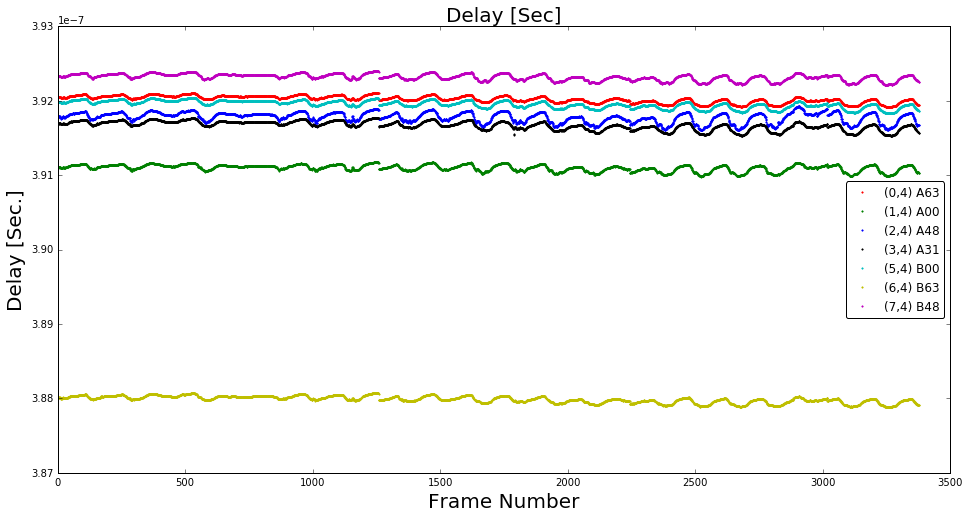

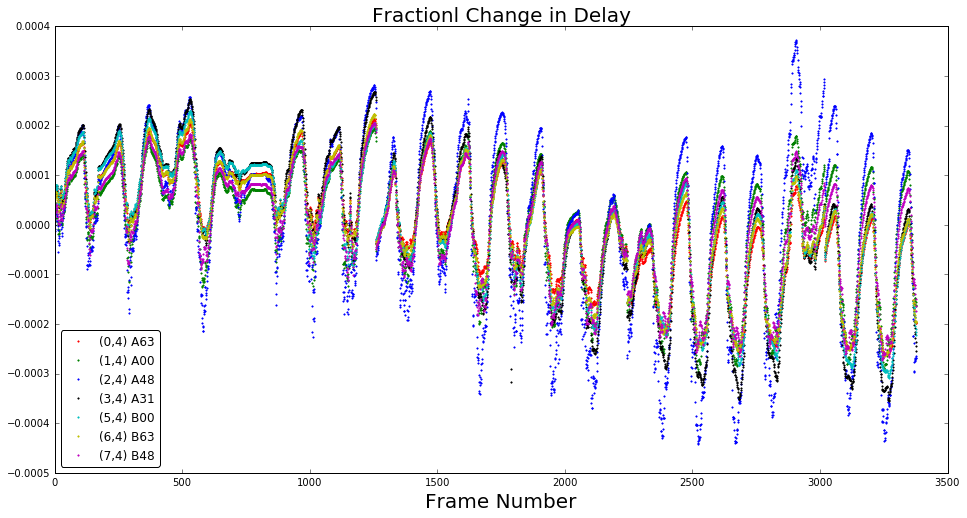

In [10]:
figure(figsize(16,8))
#plt.title('Delay [Sec.]', size=20)
plt.ylabel('Delay [Sec.]', size =20)
plt.xlabel('Frame Number', size=20)
k=1; dd=1; k=0

for i in range (len(corr_list)):  
    print(i)
    plt.plot(delay[:,i], '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    plt.title('Delay [Sec]', size=20)
    legend(loc='best', numpoints=1, fancybox=True)
    k=k+1

figure(figsize(16,8))
k=0
for i in range (len(corr_list)): 
    print(np.mean(delay[:,i]))
    plt.plot((delay[:,i] - np.mean(delay[:,i]))/np.mean(delay[:,i]), '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    plt.title('Fractionl Change in Delay', size=20)
    plt.xlabel('Frame Number', size=20)
    legend(loc='best', numpoints=1, fancybox=True)
    k=k+1

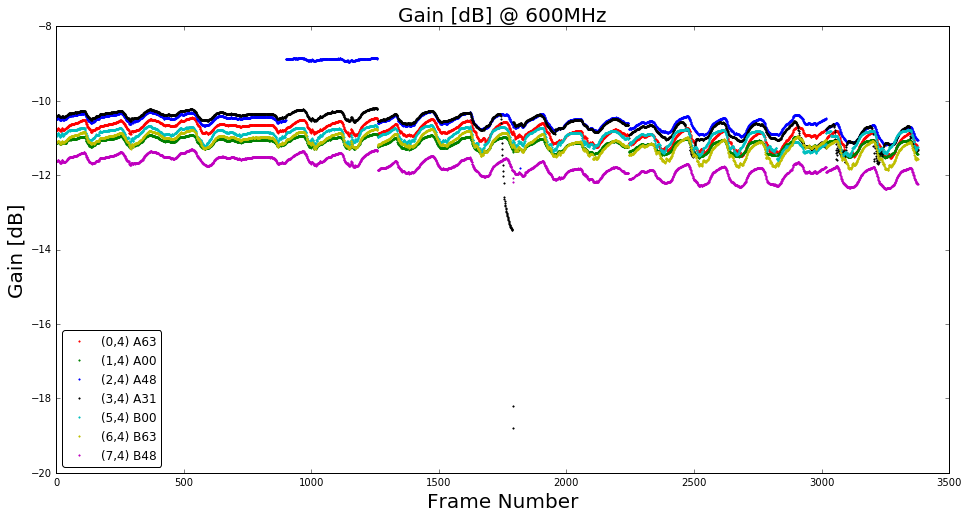

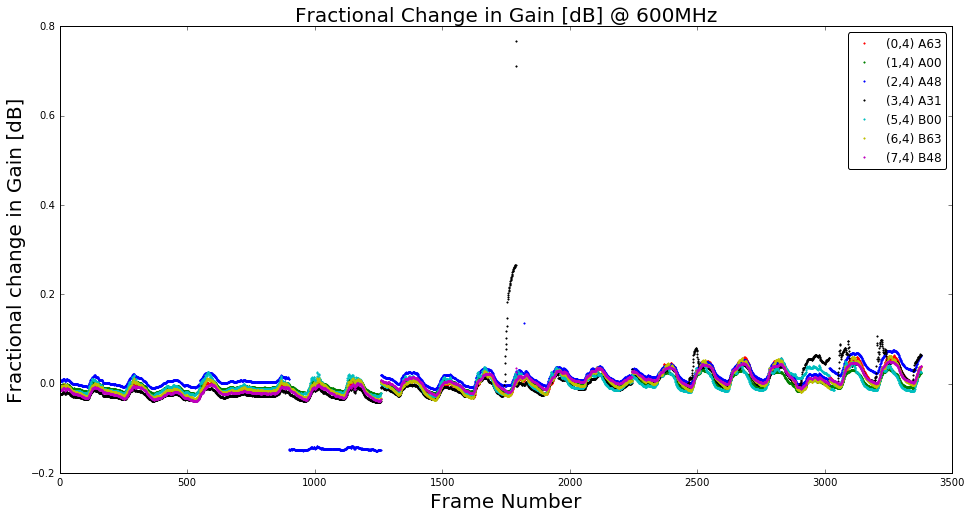

In [14]:
figure(figsize(16,8))
plt.title('Gain [dB] @ 600MHz', size=20)
plt.ylabel('Gain [dB]', size =20)
plt.xlabel('Frame Number', size=20)
k=1; dd=1; k=0
for i in range(len(corr_list)):
    plt.plot(gain_all[:,i,freq], '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    legend(loc='best', numpoints=1, fancybox=True)
    k=k+1

figure(figsize(16,8))
k=0
for i in range(len(corr_list)):
    plt.plot((gain_all[:,i,freq] - np.mean(gain_all[:,i,freq]))/np.mean(gain_all[:,i,freq]) , '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    legend(loc='best', numpoints=1, fancybox=True)
    plt.title('Fractional Change in Gain [dB] @ 600MHz', size=20)
    plt.ylabel('Fractional change in Gain [dB]', size =20)
    plt.xlabel('Frame Number', size=20)
    k=k+1

In [11]:
k=0
for corr_file in corr_files:
    print (corr_file); kk=0
    for j in range(len(corr_list)):
        slope,b = np.polyfit(freq_phase[50:990]*10**6,unwrap_phase[10][j][:],1)
        if slope<0:
            slope = slope*(-1.0)
            unwrap_phase[10][j][:] = unwrap_phase[10][j][:]*(-1.0)
        #plt.figure(k)
        ##plt.subplot(7,(j%2)+1,i/2+1)
        #plt.plot(freq_phase[50:990],unwrap_phase[10][j][:],color = colors[kk])
        #plt.title('Phase' + str(corr_file))
        kk=kk+1
    k=k+1

<HDF5 file "00000000_0000.h5" (mode r)>
<HDF5 file "00216004_0000.h5" (mode r)>
<HDF5 file "00000000_0000.h5" (mode r)>
<HDF5 file "00216003_0000.h5" (mode r)>
<HDF5 file "00000000_0000.h5" (mode r)>
<HDF5 file "00000000_0000.h5" (mode r)>
<HDF5 file "00648000_0000.h5" (mode r)>
<HDF5 file "00863999_0000.h5" (mode r)>
<HDF5 file "00000000_0000.h5" (mode r)>
<HDF5 file "00216003_0000.h5" (mode r)>
<HDF5 file "00432001_0000.h5" (mode r)>
<HDF5 file "00216003_0000.h5" (mode r)>


In [12]:
'''
f = open ("delay_all.out","r")
delay_all = np.loadtxt('delay_all.out')

f= open("gain_all.out","r")
gain_all = np.loadtxt('gain_all.out')
'''
alpha = np.zeros((len(corr_list),len(freq_phase[50:990]),para))
alpha_masked = np.zeros((len(corr_list),len(freq_phase[50:990]),para))
alpha_masked_final_600 = np.zeros((len(corr_list),para))
res_array_masked = np.zeros((len(corr_list), tot_frames))
res_array = np.zeros((len(corr_list),tot_frames)) 
frame_rep = np.arange(0,tot_frames)
gain_fit_all_600=[]

# Polynomial fitting Gain (just an example) in this we are just doing polyfitting (not what we want)

           2
1.457e-07 x - 0.00929 x - 5.274
           2
1.469e-06 x - 0.01076 x - 4.994
           2
-4.45e-06 x - 0.01309 x + 0.6172
           2
4.774e-06 x - 0.01463 x - 3.776
           2
3.044e-06 x - 0.01338 x - 4.224
           2
7.175e-06 x - 0.01772 x - 2.924
           2
1.527e-06 x - 0.01177 x - 4.761


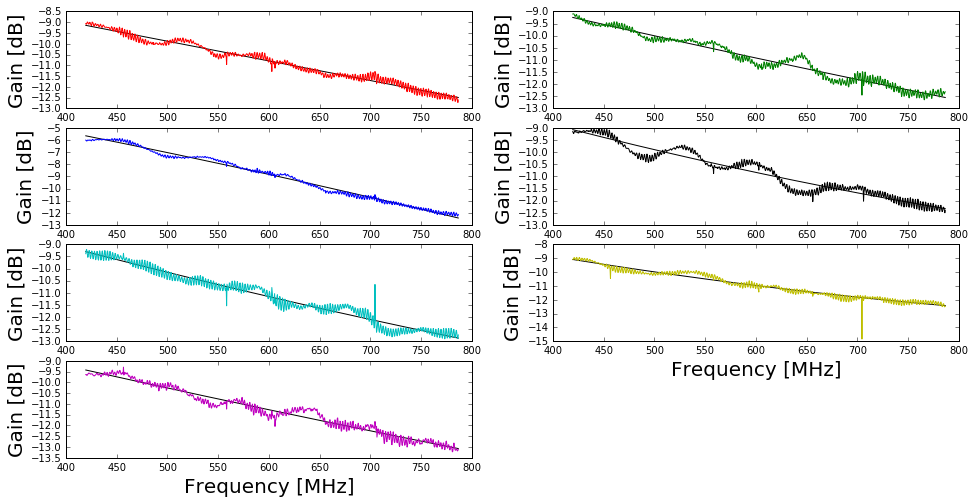

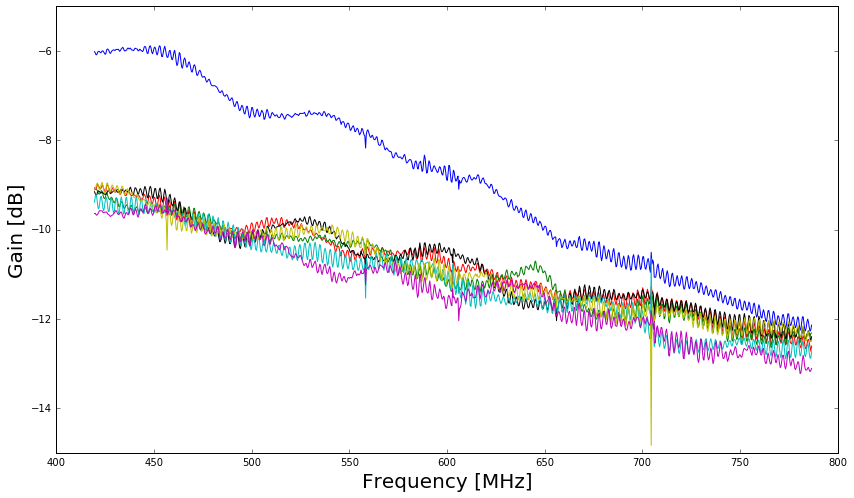

In [13]:
k=0
#figure(figsize(14,8))
#fig, ax = plt.subplots(nrows=4,ncols=4)

for i in range(len(corr_list)):
    z=np.polyfit(freq_phase[50:990], gain_all[1000,i,:],2)
    p=np.poly1d(z)
    print(p)
    #print(k); print(i%2+1)
    plt.subplot(4,2,i+1)
    #plt.title('Polynomial fitting for Gain (Single frame)', size=20)
    plt.xlabel('Frequency [MHz]', size=20)
    plt.ylabel('Gain [dB]', size =20)
    plt.plot(freq_phase[50:990], p(freq_phase[50:990]),'k')
    plt.plot(freq_phase[50:990], gain_all[1000,i,:],  label = str(legend_crosscorr[k]), color = colors[k])

    k=k+1
  
k=0
figure(figsize(14,8))
for i in range(len(corr_list)):
    plt.xlabel('Frequency [MHz]', size = 20)
    plt.ylabel('Gain [dB]', size = 20)
    plt.plot(freq_phase[50:990], gain_all[1000,i,:],  label = str(legend_crosscorr[k]), color = colors[k])
    k=k+1


In [18]:
def gain_fit(x,*p):
    #return p[0]*(np.cos(2*np.pi*p[1]*x/(0.84*300)+p[2])) + p[3]*(np.cos(2*np.pi*p[4]*x/(0.84*300)+p[5])) +p[6]*(np.cos(2*np.pi*p[7]*x/(0.84*300)+p[8])) +p[9] 
    return p[0]*(np.cos(2*np.pi*p[1]*x/(0.84*300)+p[2])) + p[3]*(np.cos(2*np.pi*p[4]*x/(0.84*300)+p[5])) +p[6]*x + p[7]
    #return p[0]*(np.cos(2*np.pi*100*x/(0.84*300)+p[4])) + p[1]*(np.cos(2*np.pi*4*x/(0.84*300)+p[5])) +p[2]*x +p[3]
    #return p[0]*(np.cos(2*np.pi*(p[1]+1)*100/(0.84*300)+p[2])) + p[3]*(np.cos(2*np.pi*(p[4]+1)*x/(0.84*300)+p[5])) +p[6]*x + p[7]

def gain_fit_2(x,*p):   
    return p[0]*(np.cos(2*np.pi*(p[1]+1)*100/(0.84*300)+p[2])) + p[3]*(np.cos(2*np.pi*(p[4]+1)*x/(0.84*300)+p[5])) +p[6]*x + p[7]

def gain_fit_3(x,*p):
    return p[0]*(np.cos(2*np.pi*100*x/(0.84*300)+p[4])) + p[1]*(np.cos(2*np.pi*4*x/(0.84*300)+p[5])) +p[2]*x +p[3]

def gain_fit_5(x,*p):
    return p[0]*(np.cos(2*np.pi*p[1]*x/(0.84*300)+p[2])) + p[3]*(np.cos(2*np.pi*p[4]*x/(0.84*300)+p[5])) +p[6]*(np.cos(2*np.pi*p[7]*x/(0.84*300)+p[8])) +p[9] 

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


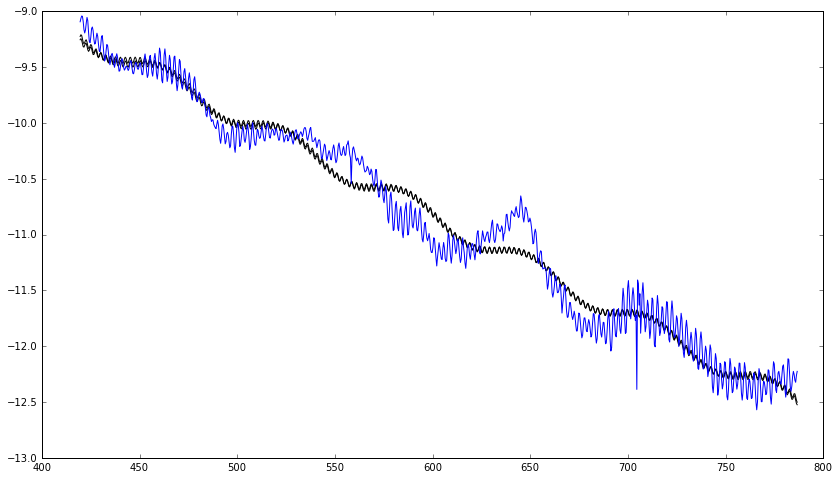

In [19]:
para_1,conv = curve_fit(gain_fit, freq_phase[50:990], gain_all[10,1,:], p0=(1,100,0,1,4,0,1,0))
para_2,conv = curve_fit(gain_fit_2, freq_phase[50:990], gain_all[10,1,:], p0=(1,1,1,1,1,1,1,1))
para_3,conv = curve_fit(gain_fit_3, freq_phase[50:990], gain_all[10,1,:], p0=(1,1,1,1,1,1,1,1))
#xx,conv = curve_fit(gain_fit, freq_phase[50:990], gain_all[10,1,:], p0=(1,1,1,1,1,1))
#print ('Amplitude1', xx[0])
#print ('Del_length1', xx[1])
#print ('Del_length2', xx[4])
#print (freq_phase)
plt.plot(freq_phase[50:990],gain_fit(freq_phase[50:990],*para_1), 'k')
#plt.plot(freq_phase[50:990],gain_fit_2(freq_phase[50:990],*para_2), 'r')
plt.plot(freq_phase[50:990],gain_fit_3(freq_phase[50:990],*para_3), 'k')
plt.plot(freq_phase[50:990], gain_all[10,1,:])

# IFFT and seperating the three components to see whether the fit is sinusoidal or not! gain_all[10,1,:]

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


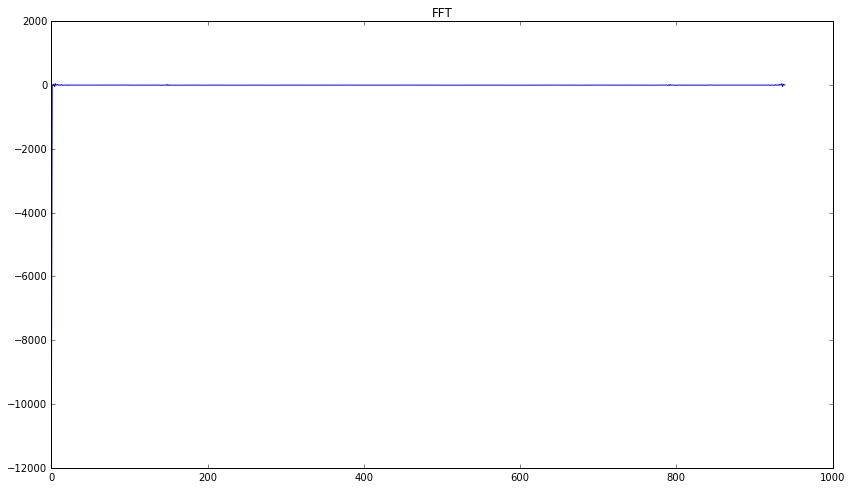

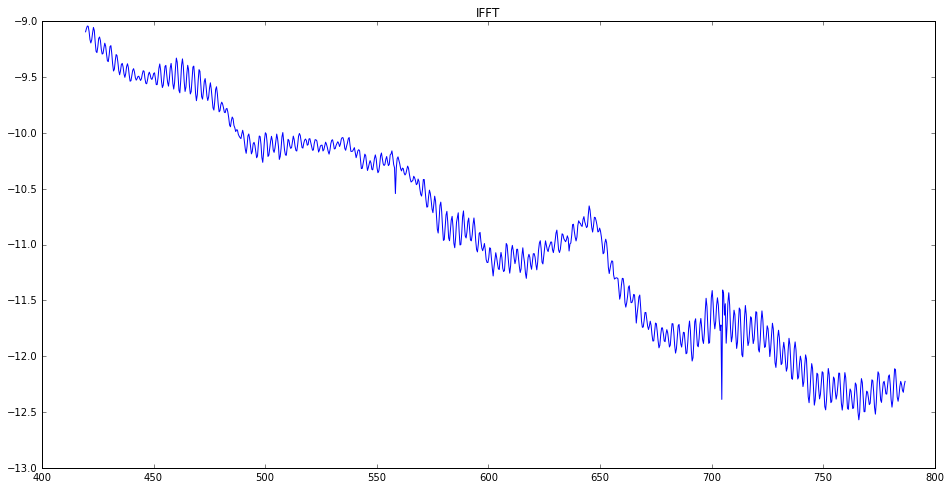

In [14]:
fft_component=(np.fft.fft(gain_all[10,1,:]))
filter_fft = (fft_component)
ifft_component = np.fft.ifft(filter_fft)
#print(ifft_component)

plt.plot(fft_component)
plt.title('FFT')

figure(figsize(16,8))
plt.plot(freq_phase[50:990],ifft_component)
plt.title('IFFT')

#

 
-0.008925 x - 5.479
 
-0.008925 x - 5.479
 
-0.008925 x - 5.479
 
-0.008925 x - 5.479
 
-0.008925 x - 5.479
 
-0.008925 x - 5.479
 
-0.008925 x - 5.479


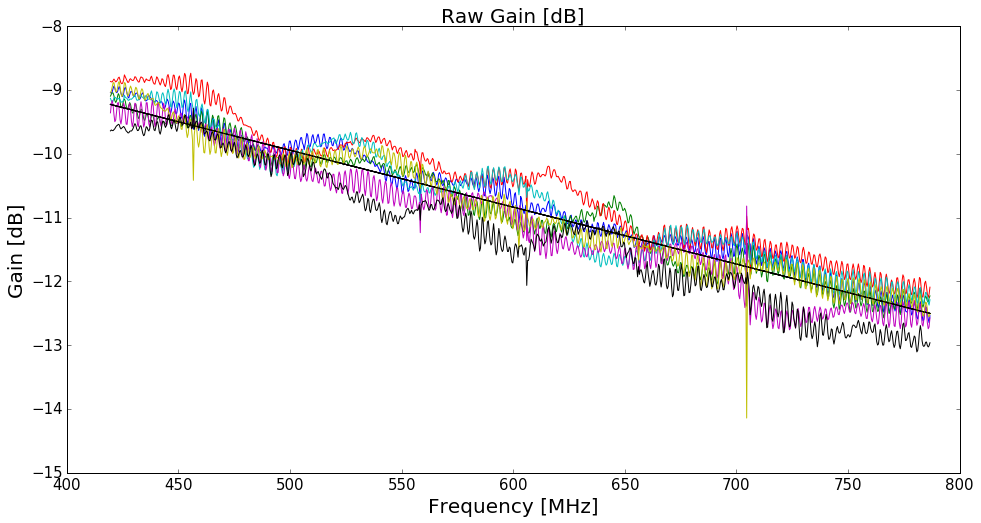

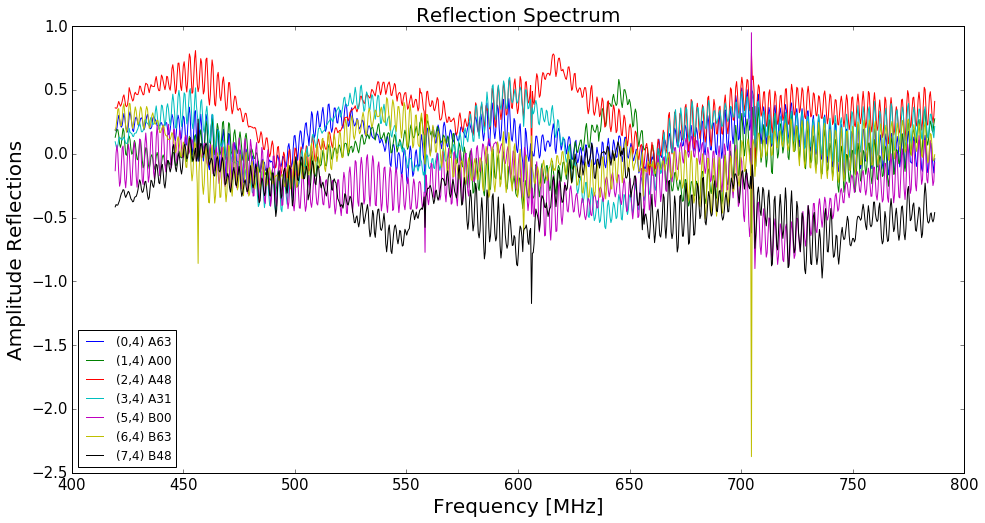

In [22]:
for i in range(len(corr_list)):
    z=np.polyfit(freq_phase[50:990], gain_all[10,1,:],1)
    p=np.poly1d(z)
    print(p)
    
    plt.figure(1)
    plt.xlabel('Frequency [MHz]', size=20)
    plt.ylabel('Gain [dB]', size =20)
    plt.plot(freq_phase[50:990], p(freq_phase[50:990]),'k', label='Linear Fit')
    plt.plot(freq_phase[50:990], gain_all[10,i,:], label='Raw Gain')
    plt.title('Raw Gain [dB]', size=20)
    plt.yticks( fontsize = 15)
    plt.xticks( fontsize = 15)

    figure(2)
    plt.plot(freq_phase[50:990], gain_all[10,i,:]-p(freq_phase[50:990]),label= legend_crosscorr[i])
    plt.xlabel('Frequency [MHz]', size=20)
    plt.ylabel('Amplitude Reflections', size =20)
    plt.title('Reflection Spectrum', size=20)
    plt.legend(loc='best')
    plt.yticks( fontsize = 15)
    plt.xticks( fontsize = 15)
    '''
    plt.figure(3)
    plt.plot(np.abs(np.fft.fft(p(freq_phase[50:990]))))
    plt.title('FFT of linear fit')
    plt.ylim(0,20)
    '''

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


NameError: name 'filtered_gain' is not defined

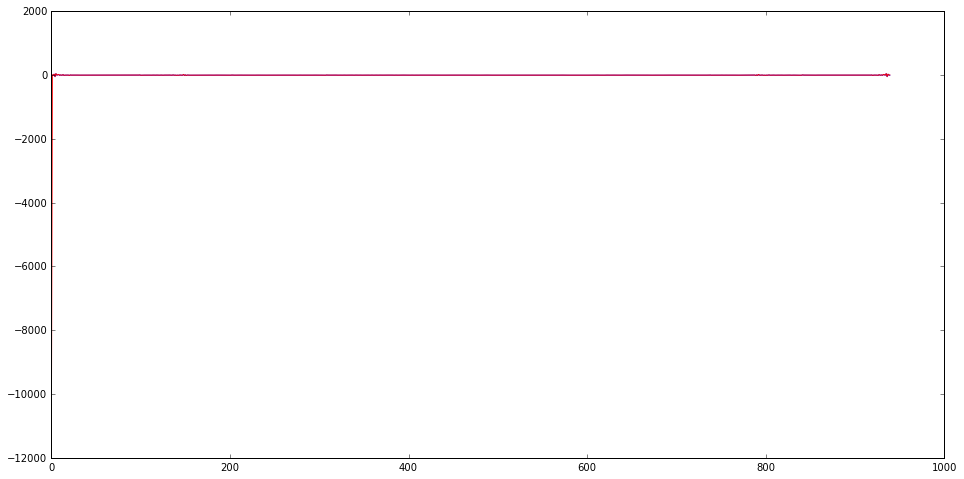

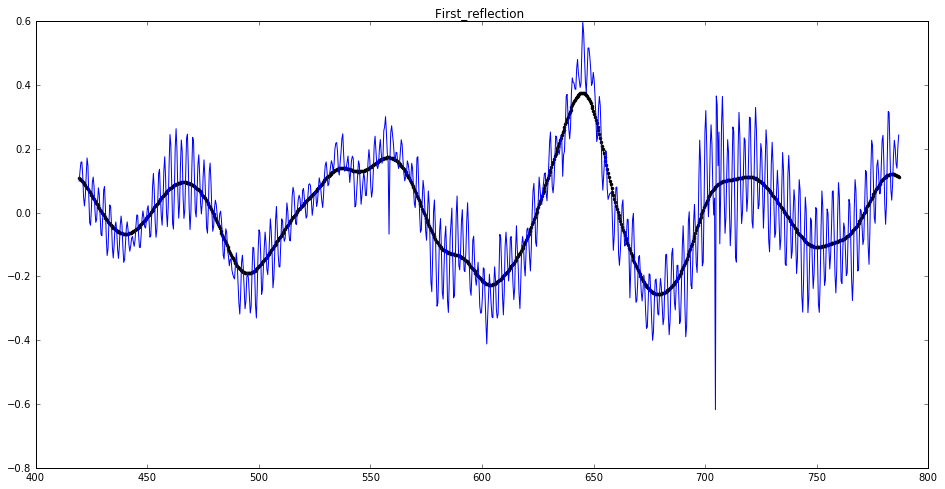

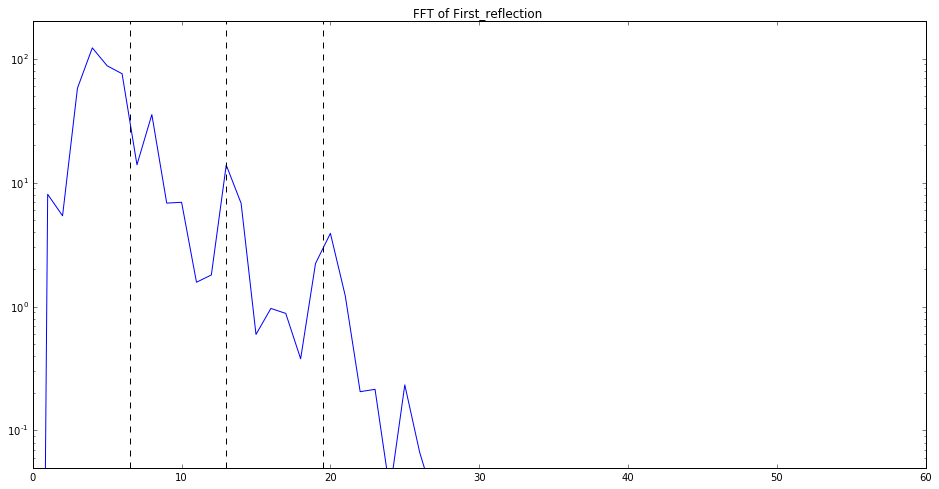

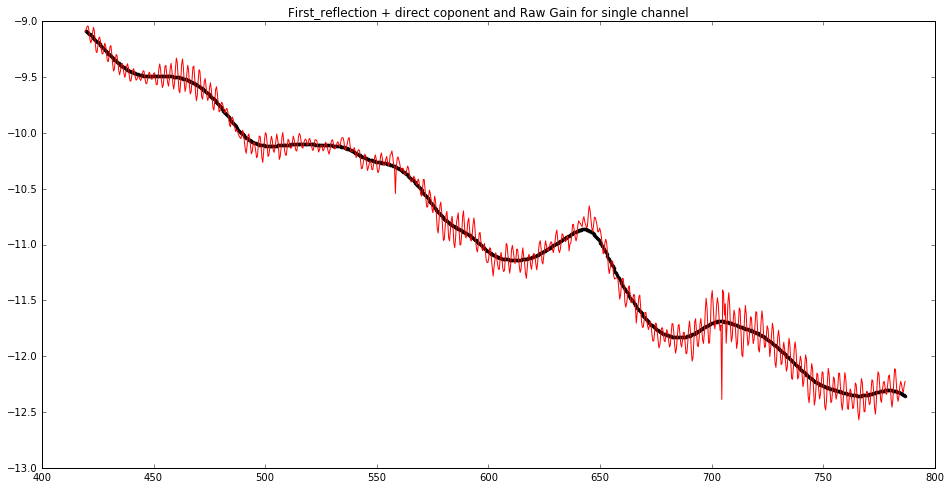

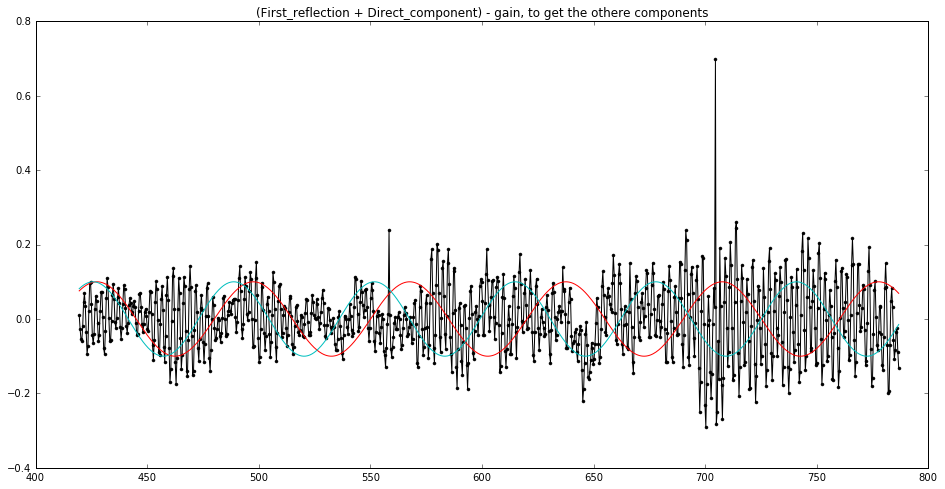

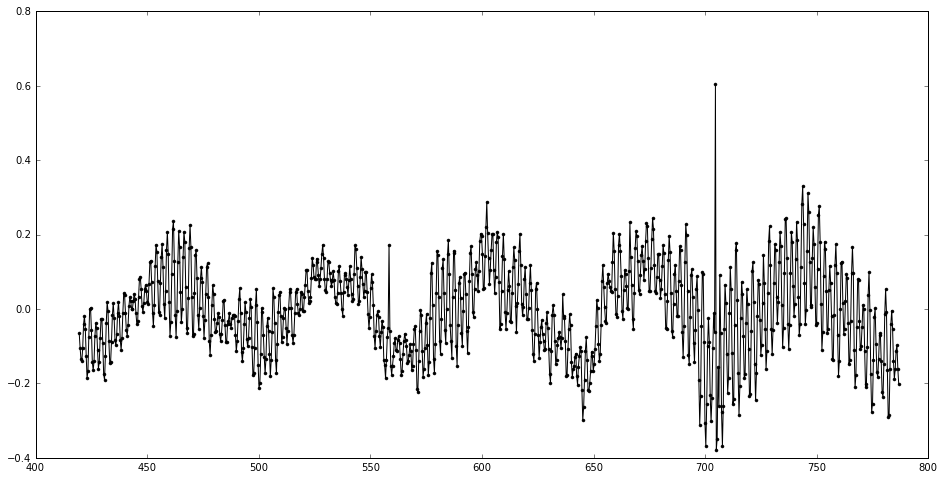

In [22]:
#subtracted the constant line from gain graph and took the fft. Setting the filter to data set after FFT. FFT of a rectangulat function is sin(x)/x curve and FFT of 
#gaussian function is smooth (check your notes)hence we are making our function to be gaussian and taking FFT again.
# setting the filter size is critical
# Figure 1: Gain after using filter in FFT. 
# 
import numpy as np

z=np.polyfit(freq_phase[50:990], gain_all[10,1,:],2)
p=np.poly1d(z)
gain_line_sub = gain_all[10,1,:] - p(freq_phase[50:990])
fft_component=np.fft.fft(gain_line_sub) 

plt.figure()
plt.plot(fft_component)
plt.plot(np.fft.fft(gain_all[10,1,:]),'r')
#plt.xlim(0,100)
#plt.ylim(-200,200.)

x_component = np.arange(len(freq_phase[50:990])) # setting the size
filter_size =10 # Filter size
#fft_component[filter_size:]=0
z=np.arange(len(fft_component))

#df=0.03
f1=np.exp(-z**2/(2.*filter_size**2))
f2=np.exp(-(1.-z)**2/(2.*filter_size**2))
fil=f1+f2

fft_component_filter = (fft_component)*fil#np.exp(-z**2/(2.*filter_size**2))
#filtered_gain = np.fft.ifft(fft_component_filter) + p(freq_phase[50:990])
first_reflection = np.fft.ifft(fft_component_filter) + p(freq_phase[50:990]) # It contains the direct coponent too

plt.figure()
plt.title('filtered IFFT filter_size %i' %(filter_size), size =20)
plt.plot(freq_phase[50:990],first_reflection- p(freq_phase[50:990]),'.-k')
plt.plot(freq_phase[50:990], gain_all[10,1,:]-p(freq_phase[50:990]))
plt.title('First_reflection ')

plt.figure()
coarse_spect=np.fft.fft(first_reflection- p(freq_phase[50:990]))
plt.plot(np.abs(coarse_spect[0:60]))
plt.title('FFT of First_reflection ')
plt.axvline(6.5, color='k', linestyle='--')
plt.axvline(6.5*2, color='k', linestyle='--')
plt.axvline(6.5*3, color='k', linestyle='--')
plt.yscale('log')
plt.ylim(.05,200.)

plt.figure()
plt.plot(freq_phase[50:990],first_reflection,'.-k')
plt.plot(freq_phase[50:990],gain_all[10,1,:],'r')
plt.title('First_reflection + direct coponent and Raw Gain for single channel' )

plt.figure()
plt.plot(freq_phase[50:990],first_reflection-gain_all[10,1,:],'.-k')
plt.plot(freq_phase[50:990],.1*np.sin(2.*3.14*(freq_phase[50:990]-410.)/70.),'r')
plt.plot(freq_phase[50:990],.1*np.sin(2.*3.14*(freq_phase[50:990]-410)/63.),'c')
plt.title('(First_reflection + Direct_component) - gain, to get the othere components')
#plt.legend('difference','marks plot','my trial')

plt.figure()
plt.plot(freq_phase[50:990],first_reflection-gain_all[10,1,:]-.1*np.sin(2.*3.14*(freq_phase[50:990]-410.)/70.),'.-k')

plt.figure()
fine_spect=np.fft.fft(filtered_gain-gain_all[10,1,:])
plt.plot(np.abs(fine_spect[0:60]))
plt.yscale('log')
plt.ylim(.05,100.)
fpeak=4.
plt.axvline(fpeak, color='k', linestyle='--')
plt.axvline(fpeak*2, color='k', linestyle='--')
plt.axvline(fpeak*3, color='k', linestyle='--')

fpeak2=10.
plt.axvline(fpeak2, color='r', linestyle='--')
plt.axvline(fpeak2*2, color='r', linestyle='--')
plt.axvline(fpeak2*3, color='r', linestyle='--')


In [23]:
# to see second reflection

#Filter
filter_size =600 # Filter size
f1=np.exp(-z**2/(2.*filter_size**2))
f2=np.exp(-(1.-z)**2/(2.*filter_size**2))
fil=f1+f2

fine_spect=np.fft.fft(filtered_gain-gain_all[10,1,:])
fft_component_filter2 = (fine_spect)*fil
second_reflection = np.fft.ifft(fft_component_filter2)

plt.figure()
plt.plot(freq_phase[50:990],second_reflection,'.-k')
plt.plot(freq_phase[50:990], filtered_gain-gain_all[10,1,:])
plt.title('Second_reflection, filter size =  %i' %(filter_size), size =20)

plt.figure()
plt.title('Difference of above 2 plots')
plt.plot(freq_phase[50:990], second_reflection- (filtered_gain-gain_all[10,1,:]))

NameError: name 'filtered_gain' is not defined

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


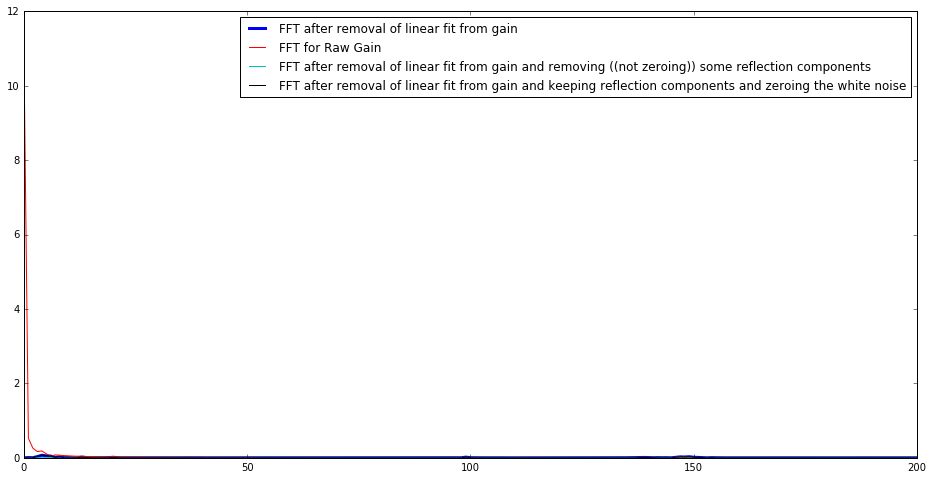

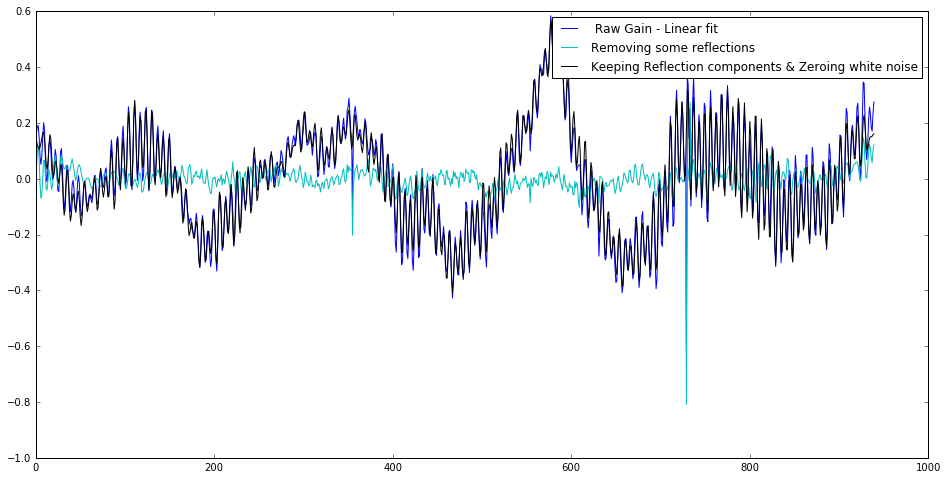

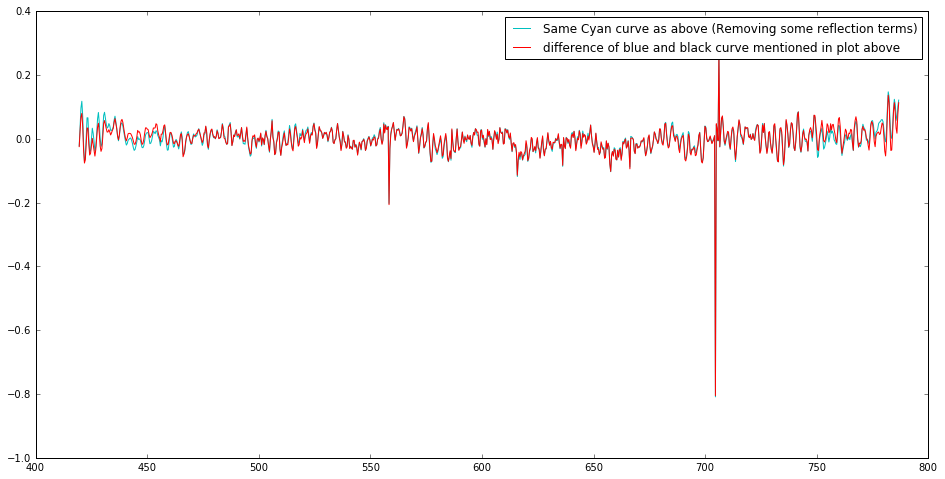

In [24]:
figure(figsize(16,8))
z=np.polyfit(freq_phase[50:990], gain_all[10,1,:],1)
p=np.poly1d(z)
gain_line_sub = gain_all[10,1,:] - p(freq_phase[50:990])

fft_component = np.fft.ifft(gain_line_sub) 

fft_component1 = np.fft.ifft(gain_line_sub) 
fft_component0 = np.fft.ifft(gain_line_sub) 
'''
fft_component1[3:9] = fft_component1[2]
fft_component1[13:15] = fft_component1[2]
fft_component1[20] = fft_component1[22]
fft_component1[99] = fft_component1[97]
fft_component1[138:141] = fft_component1[130]
fft_component1[146:153] = fft_component1[153]
fft_component1[154] = fft_component1[153]

fft_component1[789:795] = fft_component1[787]
fft_component1[786:789] = fft_component1[787]
fft_component1[800:803] = fft_component1[2]
fft_component1[841] = fft_component1[840]
fft_component1[932:938] = fft_component1[2]
fft_component1[926:928] = fft_component1[925]
fft_component1[919:922] = fft_component1[918]
'''

#print(np.abs(fft_component1[0:10]))
end = len(fft_component)

components=[3,4,5,6,7,8,13,14,20,99,138,139,140,146,147,148,149,150,151,152,154,789,790,791,792,793,794,800,801,802,841,919,920,921,926,927,932,933,934,935,936,937]

end_components = len(components)
fft_component1[components[0:6]] = fft_component1[2]
fft_component1[components[6:end_components-6]] = fft_component1[130]
fft_component1[components[end_components-6:end_components]] = fft_component1[2]
#print(components[end_components-6:end_components])
#print(end_components)


for i in range(len(fft_component)):
    if i  not in components: 
        fft_component0[i] = 0

plt.figure(1)
plt.plot(np.abs(fft_component),'b',linewidth=3,label='FFT after removal of linear fit from gain')
plt.plot(np.abs(np.fft.ifft(gain_all[10,1,:])),'r', label ='FFT for Raw Gain')
plt.plot(np.abs(fft_component1), 'c', label='FFT after removal of linear fit from gain and removing ((not zeroing)) some reflection components')
plt.plot(np.abs(fft_component0), 'k', label='FFT after removal of linear fit from gain and keeping reflection components and zeroing the white noise')
plt.xlim(0,200)
#plt.ylim(0,50)
plt.legend()

ifft_fft_component = (np.fft.fft(fft_component))
ifft_fft_component0 = (np.fft.fft(fft_component0))
ifft_fft_component1 = (np.fft.fft(fft_component1))


plt.figure()
plt.plot(ifft_fft_component,'b',label=' Raw Gain - Linear fit')
plt.plot(ifft_fft_component1,'c', label='Removing some reflections')
plt.plot(ifft_fft_component0,'k', label='Keeping Reflection components & Zeroing white noise')
plt.legend()

plt.figure()
plt.plot(freq_phase[50:990], ifft_fft_component1,'c', label='Same Cyan curve as above (Removing some reflection terms)')
plt.plot(freq_phase[50:990], ifft_fft_component-ifft_fft_component0,'r', label='difference of blue and black curve mentioned in plot above')
plt.legend()



C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


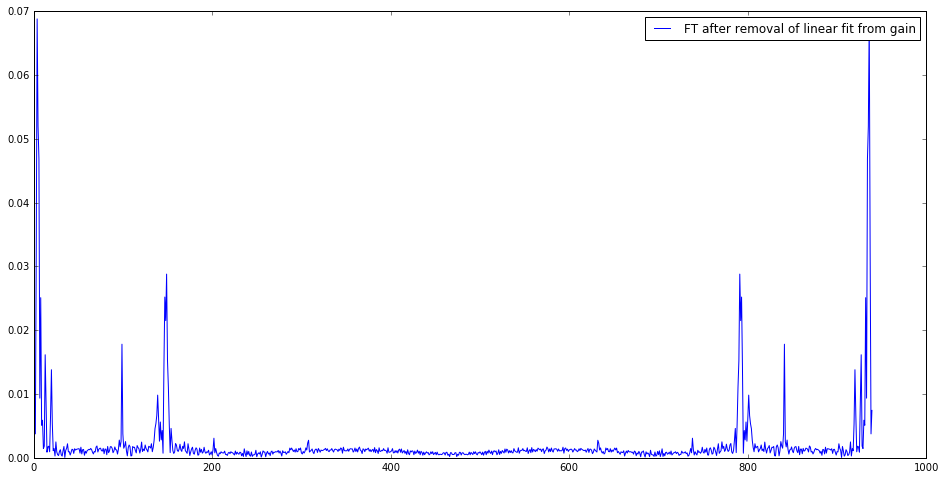

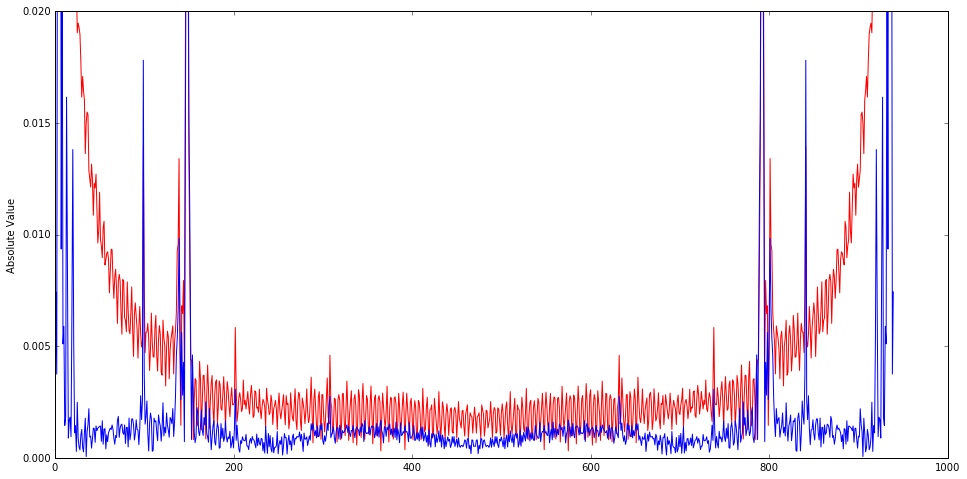

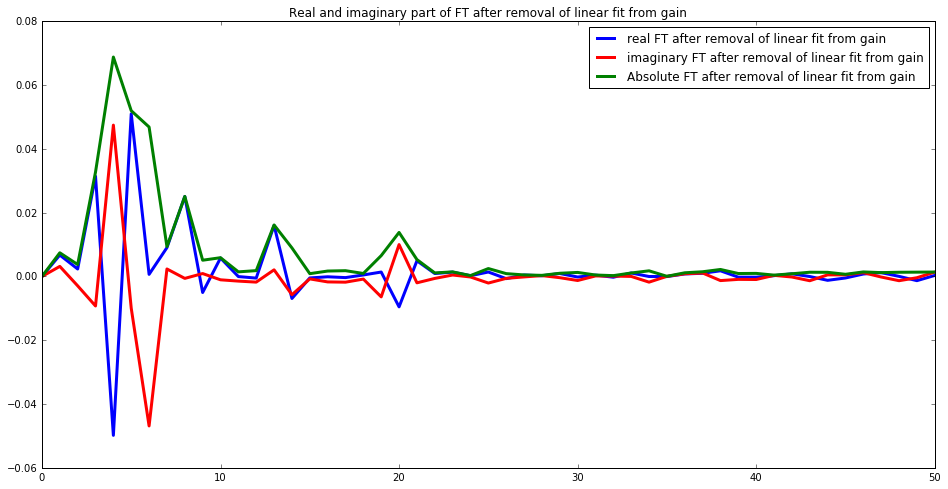

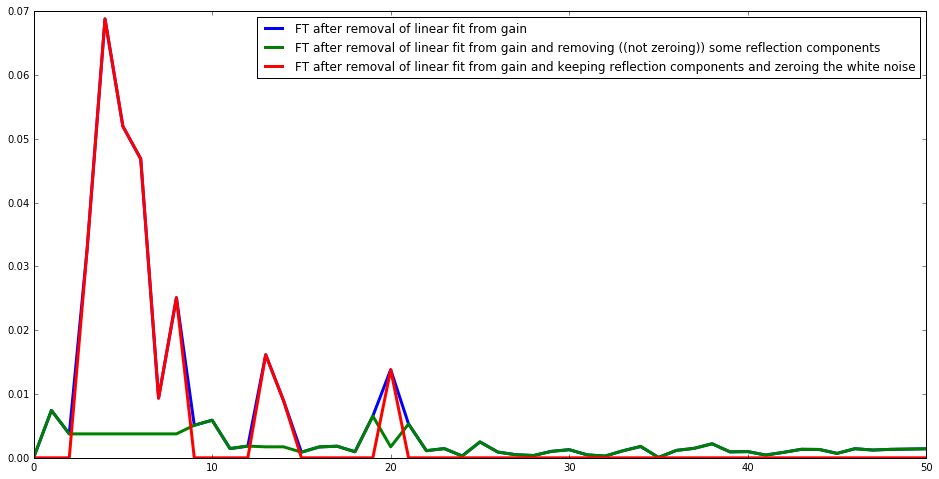

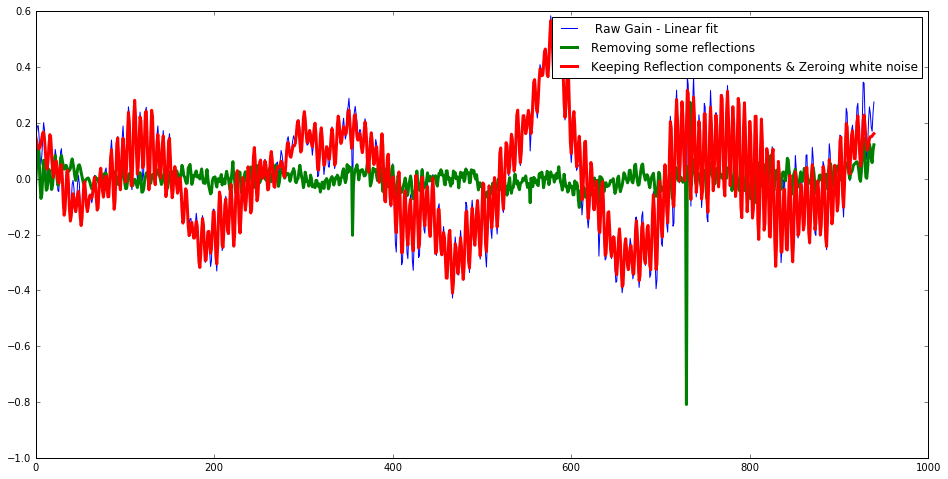

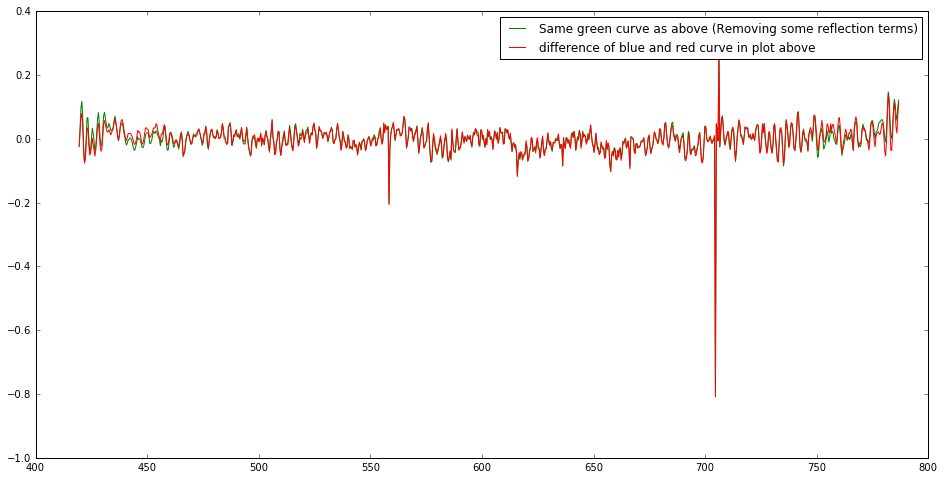

In [25]:
figure(figsize(16,8))
plt.figure()
plt.plot(np.abs(fft_component),'b',label='FT after removal of linear fit from gain')
plt.legend()

plt.figure()
plt.plot(np.abs(np.fft.ifft(gain_all[10,1,:])),'r',label='IFFT of gain')
plt.plot(np.abs(np.fft.ifft(gain_line_sub)),label='IFFT of gain-linear fit')
plt.ylim(0,0.02)
plt.ylabel('Absolute Value')


fft_component = np.fft.ifft(gain_line_sub) 
fft_component1 = np.fft.ifft(gain_line_sub) 
fft_component0 = np.fft.ifft(gain_line_sub) 
end = len(fft_component)

components=[3,4,5,6,7,8,13,14,20,99,138,139,140,146,147,148,149,150,151,152,154,789,790,791,792,793,794,800,801,802,841,919,920,921,926,927,932,933,934,935,936,937]

end_components = len(components)
fft_component1[components[0:6]] = fft_component1[2]
fft_component1[components[6:end_components-6]] = fft_component1[130]
fft_component1[components[end_components-6:end_components]] = fft_component1[2]
#print(components[end_components-6:end_components])
#print(end_components)


for i in range(len(fft_component)):
    if i  not in components: 
        fft_component0[i] = 0

plt.figure()
plt.plot(np.real(fft_component),'b',linewidth=3,label='real FT after removal of linear fit from gain')
plt.plot(np.imag(fft_component),'r',linewidth=3,label='imaginary FT after removal of linear fit from gain')
plt.plot(np.abs(fft_component),'g',linewidth=3,label='Absolute FT after removal of linear fit from gain')
plt.title('Real and imaginary part of FT after removal of linear fit from gain')
plt.xlim(0,50)
plt.legend()
        
plt.figure()
plt.plot(np.abs(fft_component),'b',linewidth=3,label='FT after removal of linear fit from gain')
#plt.plot(np.abs(np.fft.fft(gain_all[10,1,:])),'r', label ='FFT for Raw Gain')
plt.plot(np.abs(fft_component1), 'g',linewidth=3, label='FT after removal of linear fit from gain and removing ((not zeroing)) some reflection components')
plt.plot(np.abs(fft_component0), 'r',linewidth=3, label='FT after removal of linear fit from gain and keeping reflection components and zeroing the white noise')
plt.xlim(0,50)
#plt.ylim(0,50)

plt.legend()

ifft_fft_component = (np.fft.fft(fft_component))
ifft_fft_component0 = (np.fft.fft(fft_component0))
ifft_fft_component1 = (np.fft.fft(fft_component1))


plt.figure()
plt.plot(ifft_fft_component,'b',label=' Raw Gain - Linear fit')
plt.plot(ifft_fft_component1,'g',linewidth=3, label='Removing some reflections')
plt.plot(ifft_fft_component0,'r',linewidth=3, label='Keeping Reflection components & Zeroing white noise')
plt.legend()

plt.figure()
plt.plot(freq_phase[50:990], ifft_fft_component1,'g', label='Same green curve as above (Removing some reflection terms)')
plt.plot(freq_phase[50:990], ifft_fft_component-ifft_fft_component0,'r', label='difference of blue and red curve in plot above')
plt.legend()


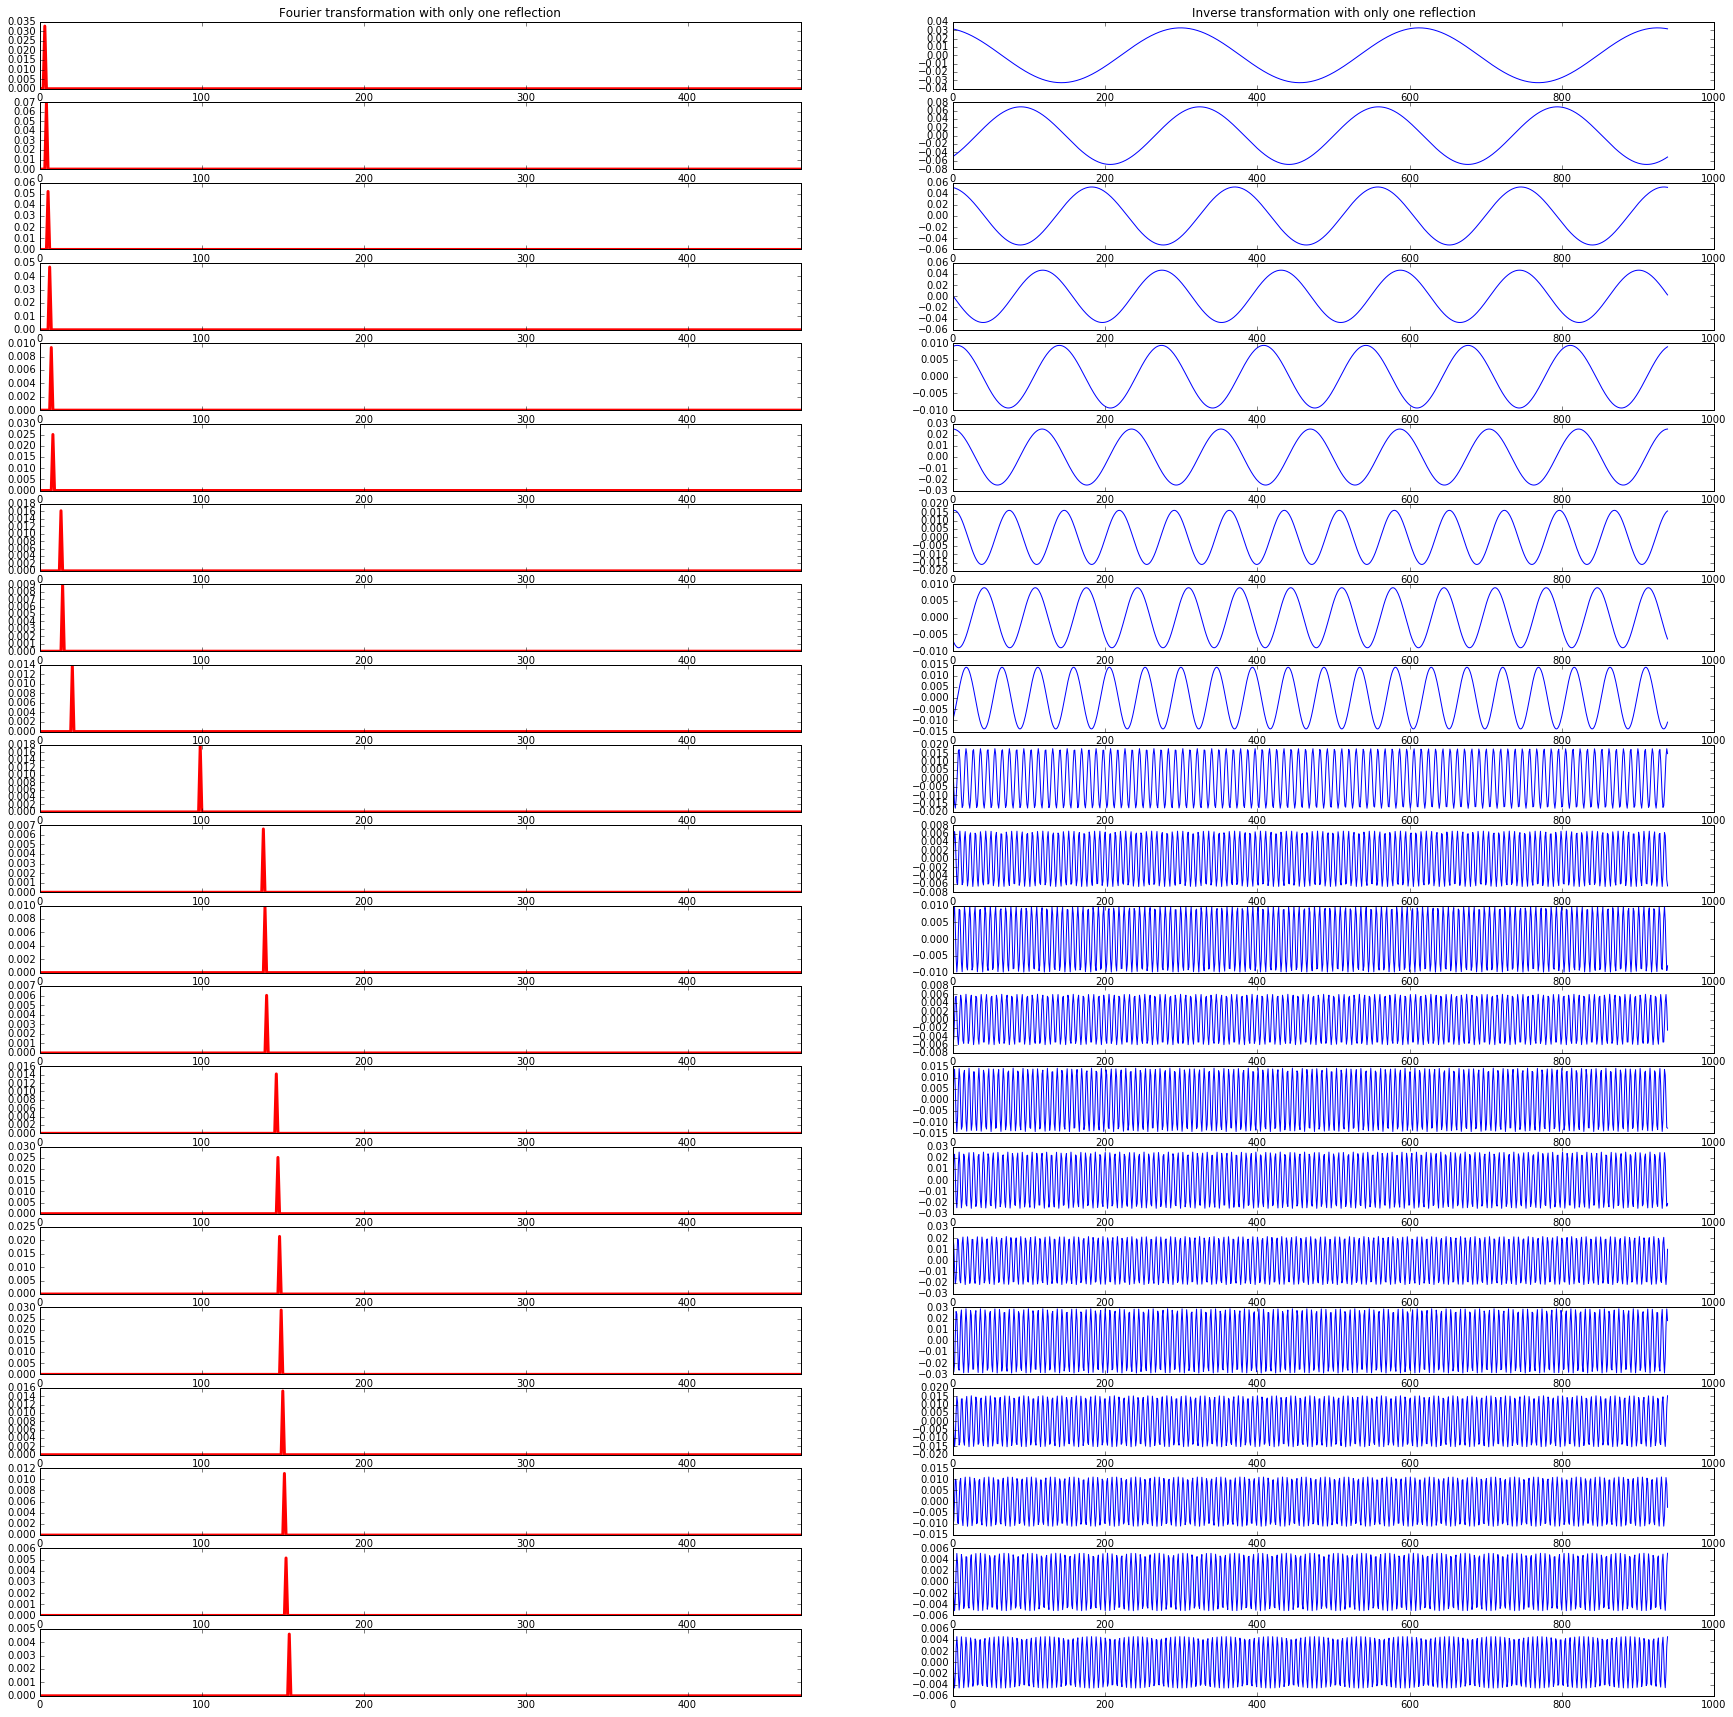

In [26]:
components_half=[3,4,5,6,7,8,13,14,20,99,138,139,140,146,147,148,149,150,151,152,154]

fig,ax = plt.subplots(len(components_half),2,figsize=(30, 30), facecolor='w', edgecolor='k')
all_comp_added = np.zeros(940)
for i in range(len(components_half)):
    fft_one_reflection = np.zeros(len(fft_component))
    fft_reflection = np.fft.ifft(gain_line_sub)#np.zeros(len(fft_component))#
    for kk in range(len(fft_component)):
        if kk != components_half[i]:
            fft_reflection[kk]=0
    
    fft_reflections_half = np.real((np.fft.fft(fft_reflection)))
    all_comp_added = all_comp_added + fft_reflections_half
    
    plt.figure(1)
    
    ax[i,0].plot(np.abs(fft_reflection),'r', linewidth =3)
    ax[i,0].set_xlim([0,470])
    #ax[i,0].set_ylim([0,65])
    ax[0,0].set_title('Fourier transformation with only one reflection')
    ax[0,1].set_title('Inverse transformation with only one reflection')
    ax[i,1].plot(fft_reflections_half,'b')
    


 
-0.008925 x - 5.479


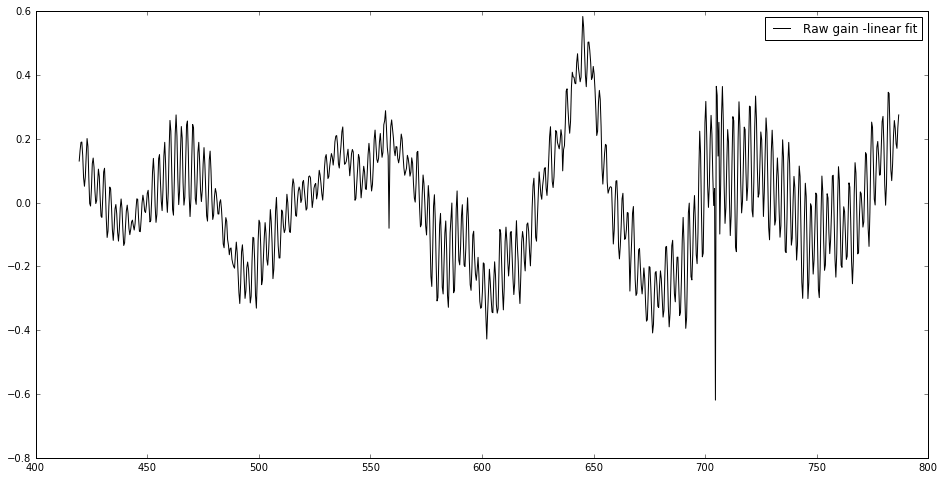

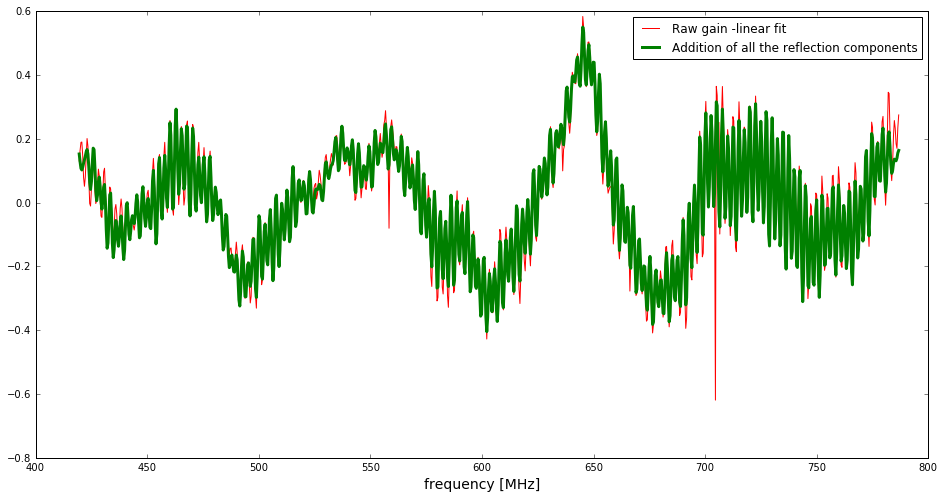

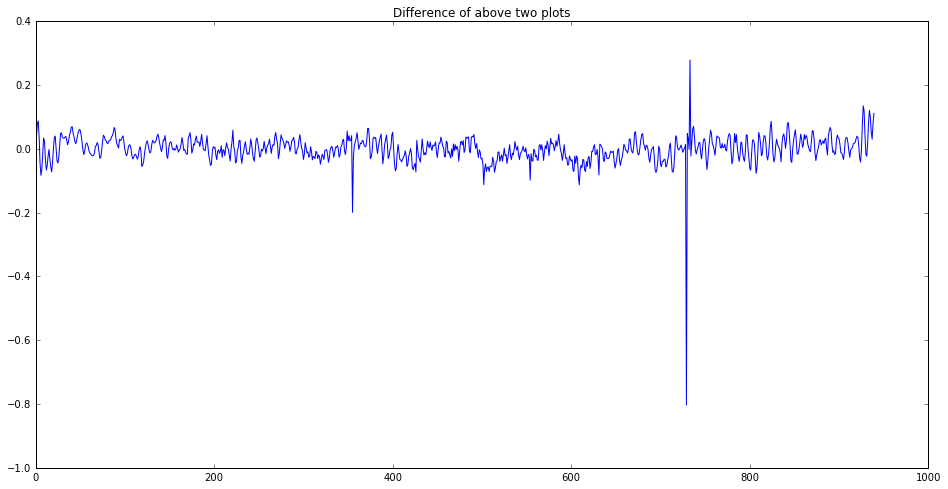

In [27]:
z=np.polyfit(freq_phase[50:990], gain_all[10,1,:],1)
p=np.poly1d(z)
print(p)

figure(1)
plt.plot(freq_phase[50:990],gain_all[10,1,:]-p(freq_phase[50:990]),'k',label='Raw gain -linear fit')
plt.legend()

figure(2)
plt.plot(freq_phase[50:990],gain_all[10,1,:]-p(freq_phase[50:990]),'r',label='Raw gain -linear fit')
plt.plot(freq_phase[50:990],2*all_comp_added,'g',linewidth=3,label='Addition of all the reflection components')
plt.xlabel('frequency [MHz]', fontsize=14)
plt.legend()

plt.figure(3)
plt.plot(gain_all[10,1,:]-p(freq_phase[50:990])-2*all_comp_added)
plt.title('Difference of above two plots')


# reflection terms fitting to get the frequency

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


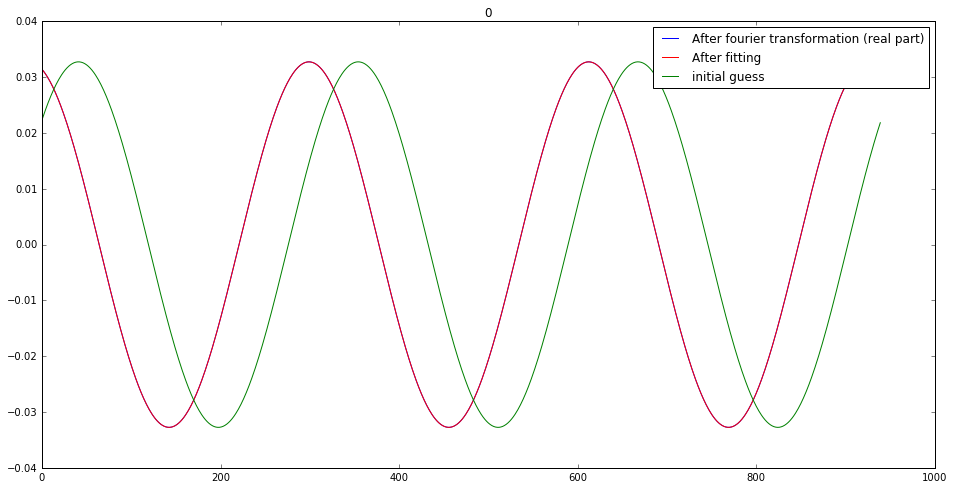

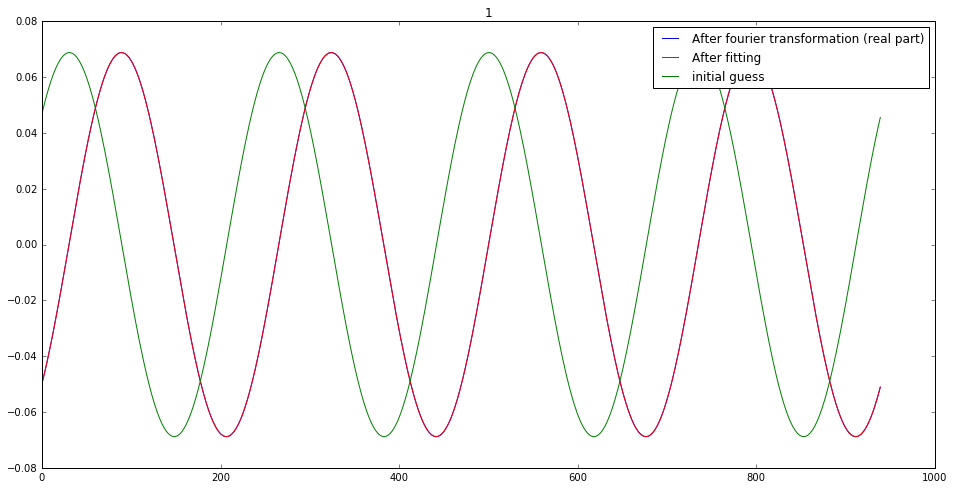

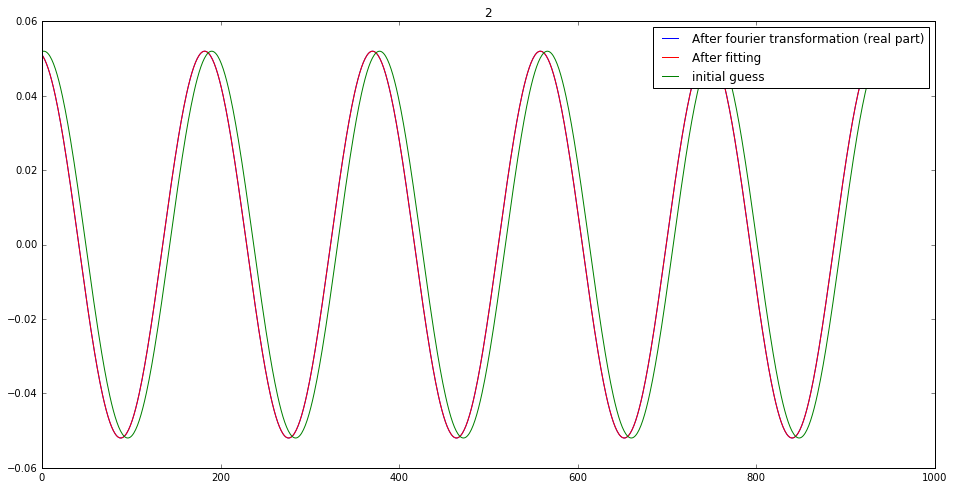

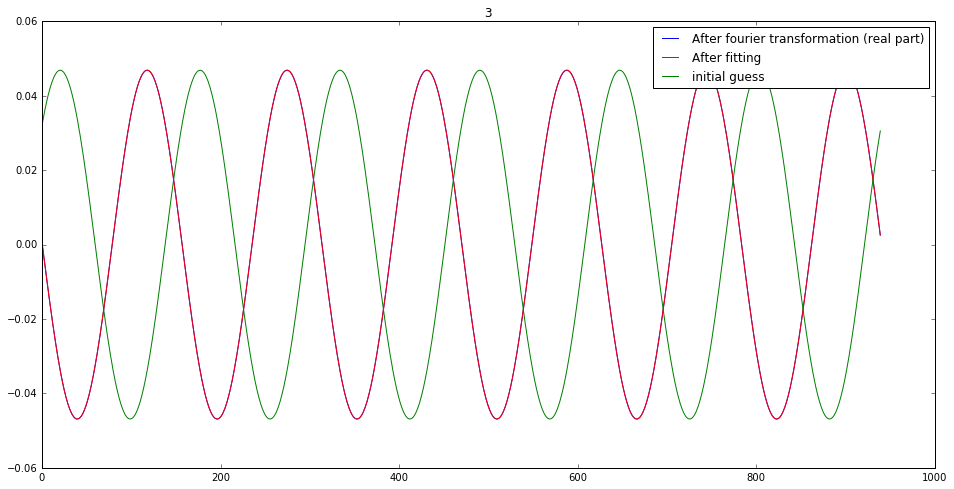

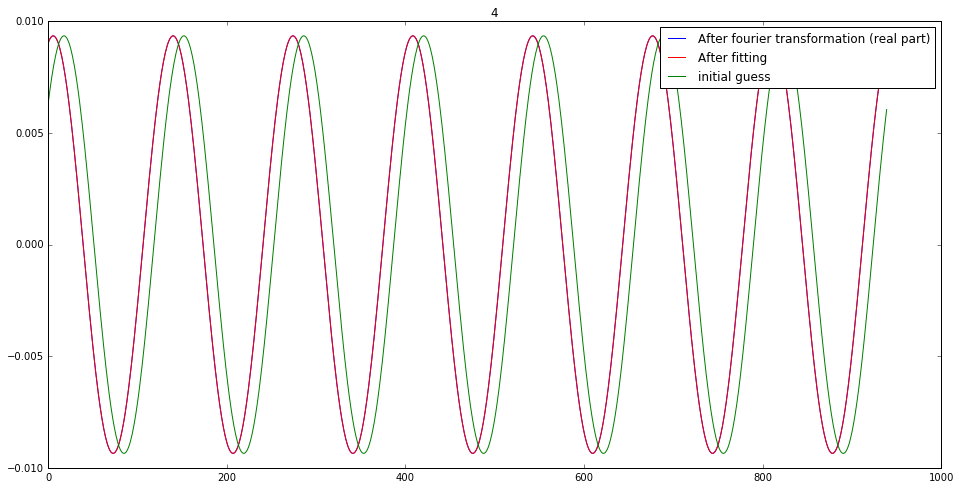

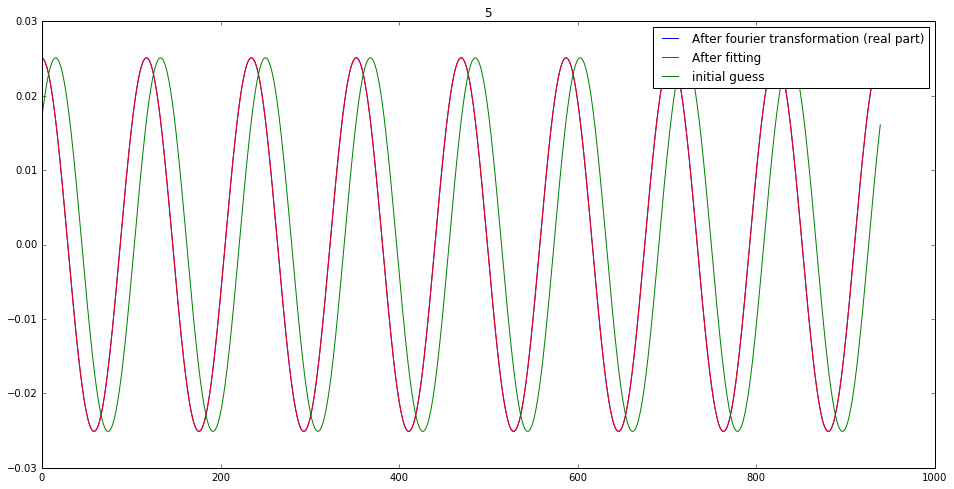

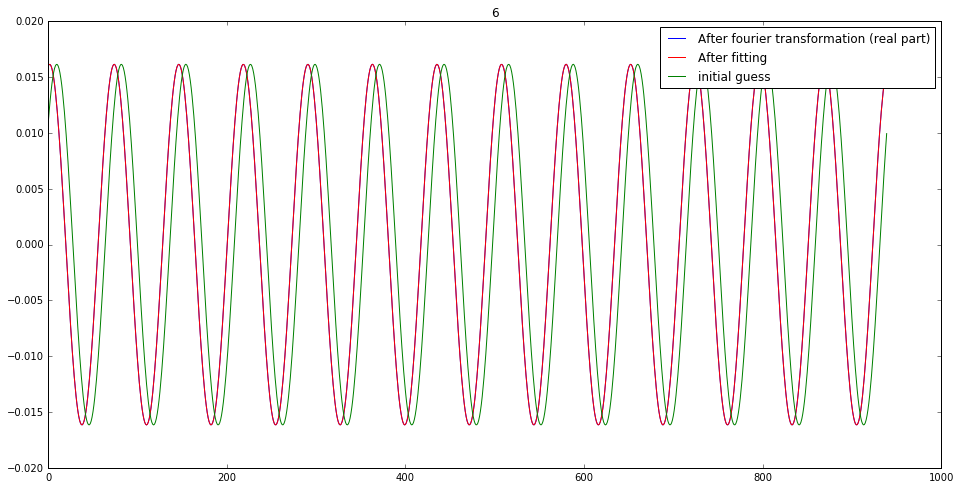

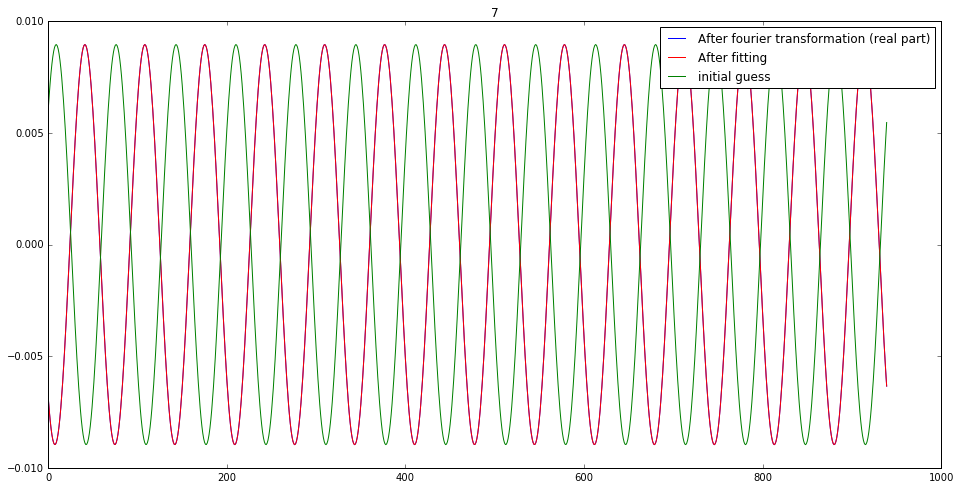

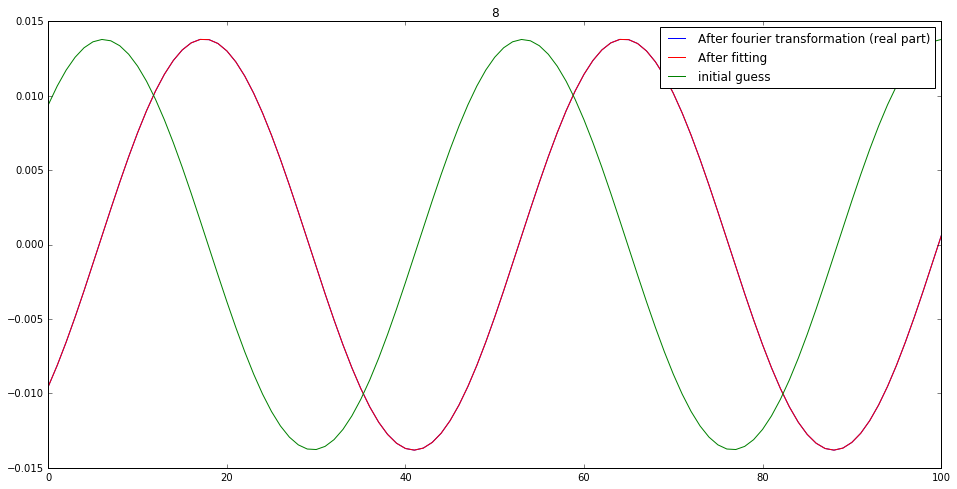

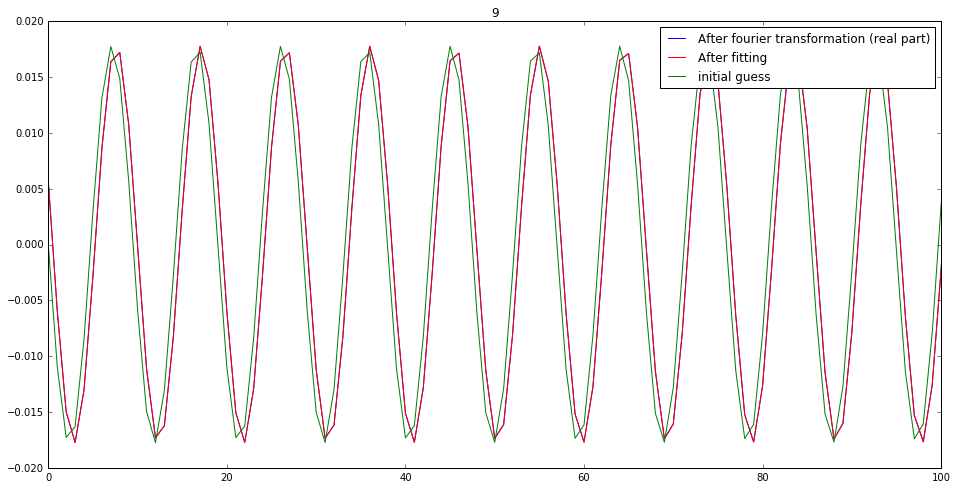

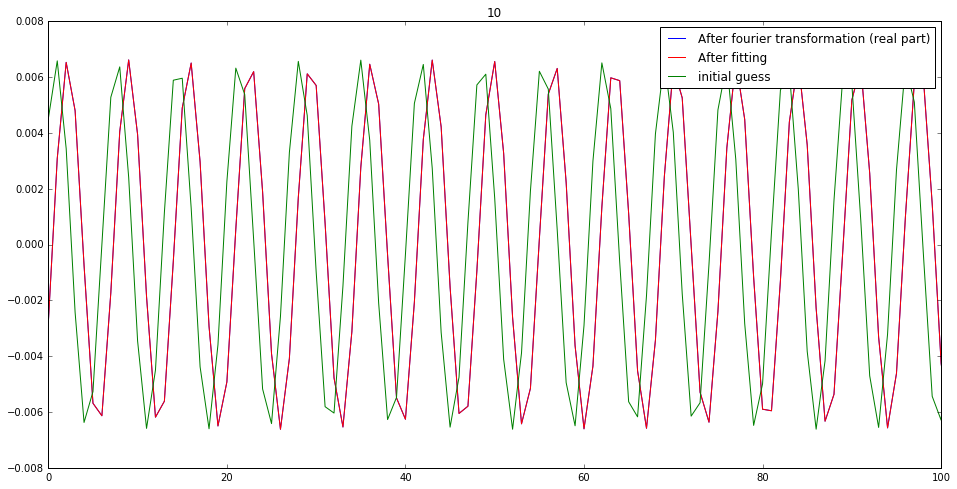

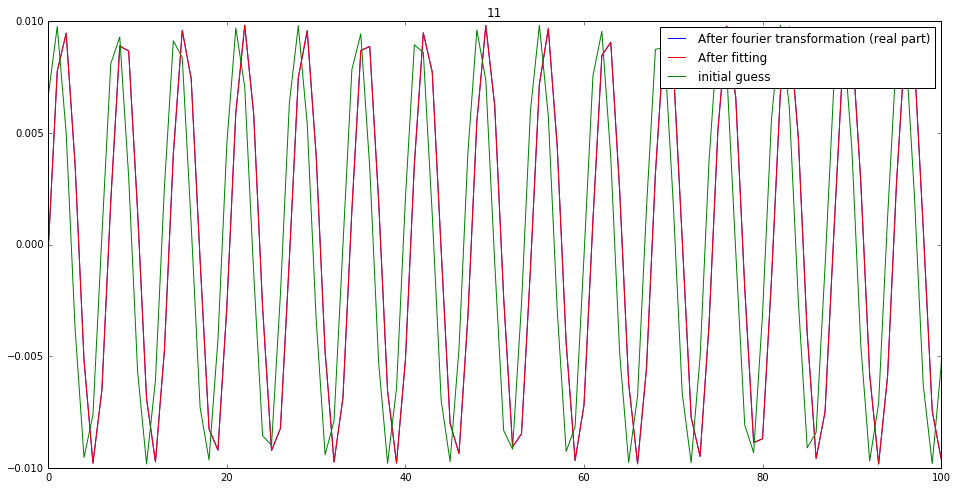

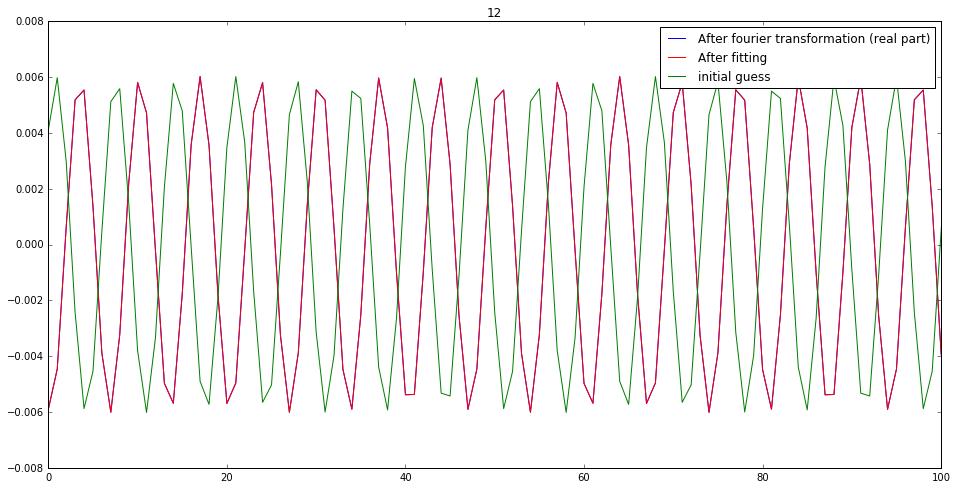

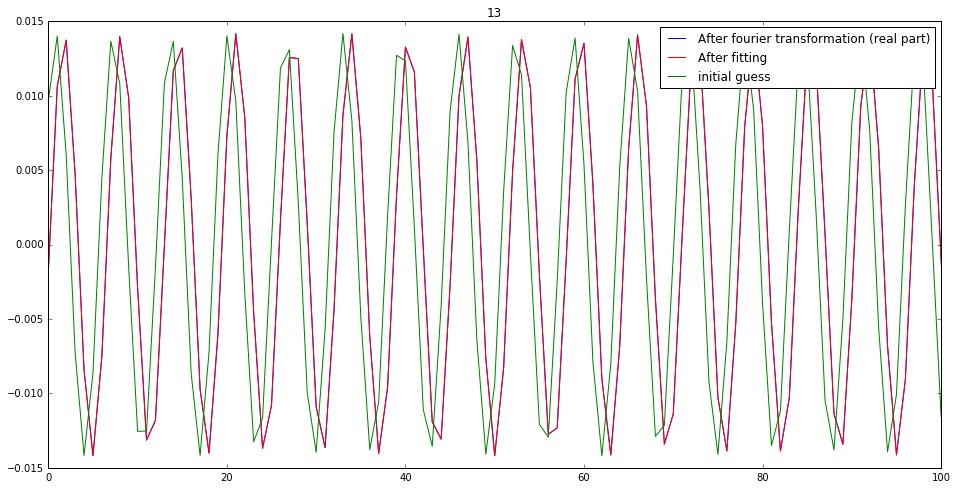

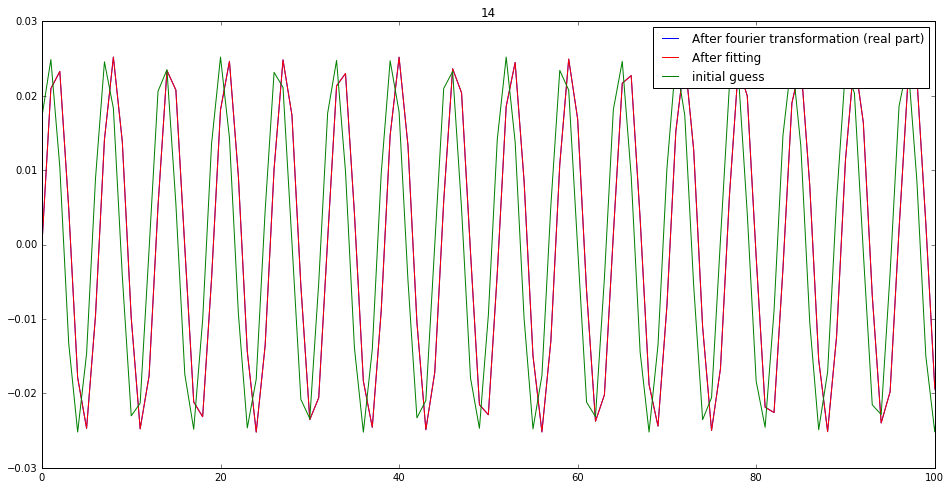

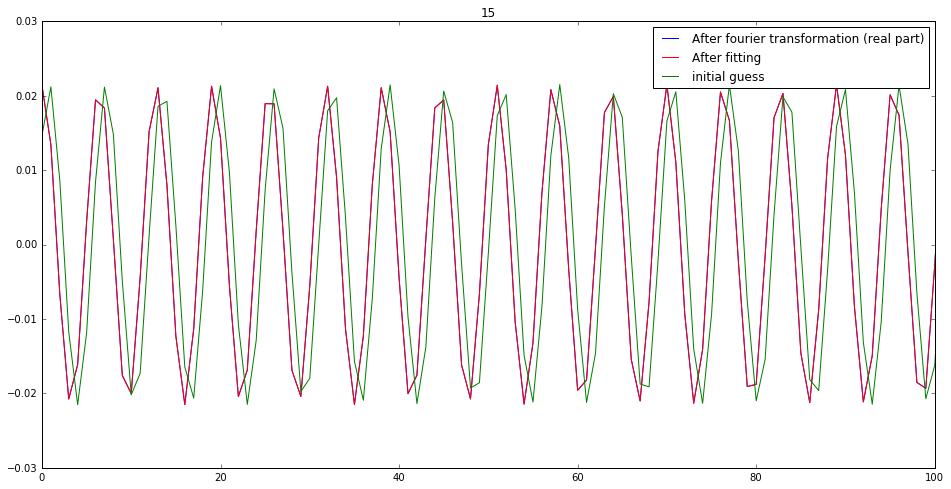

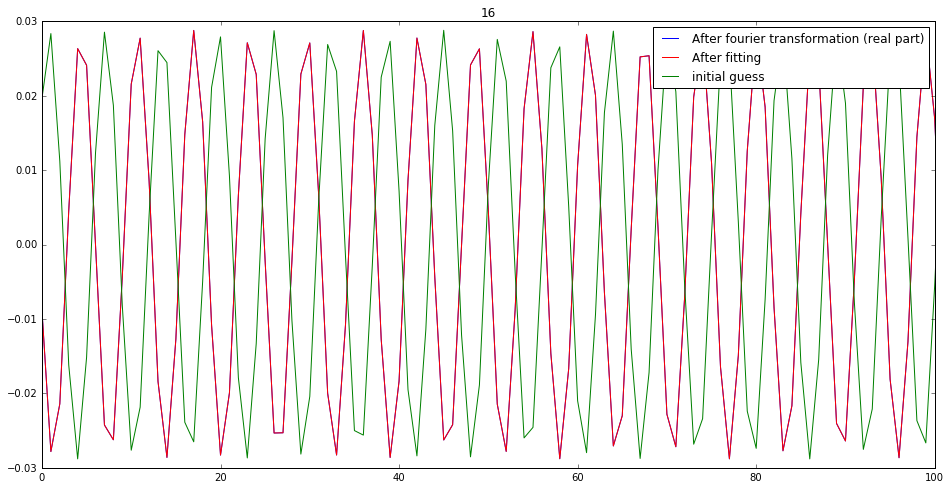

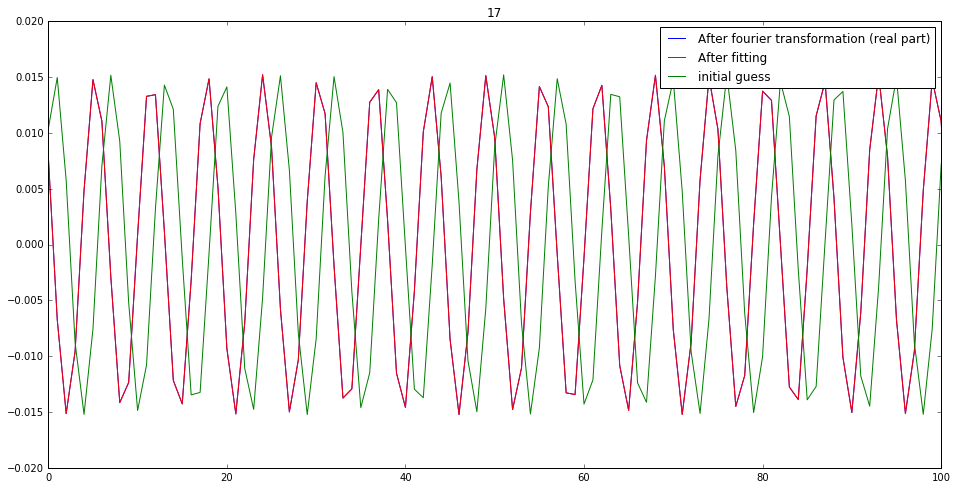

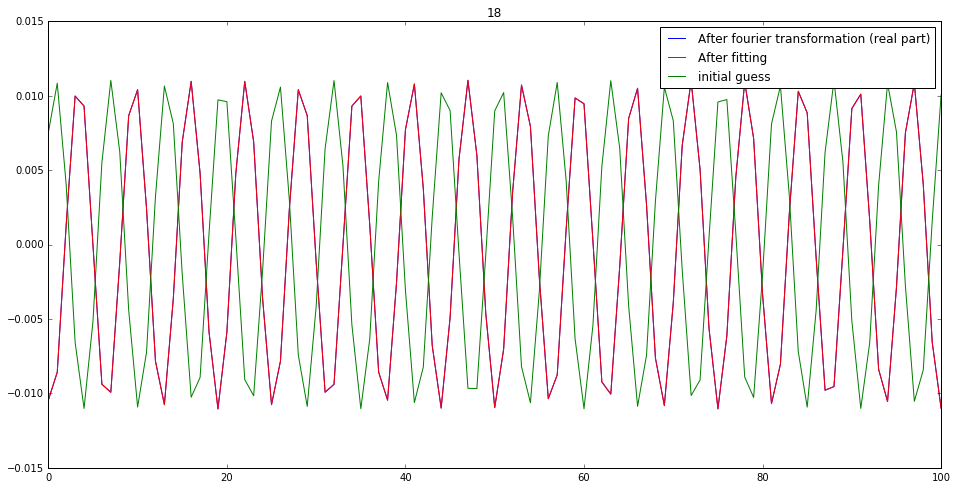

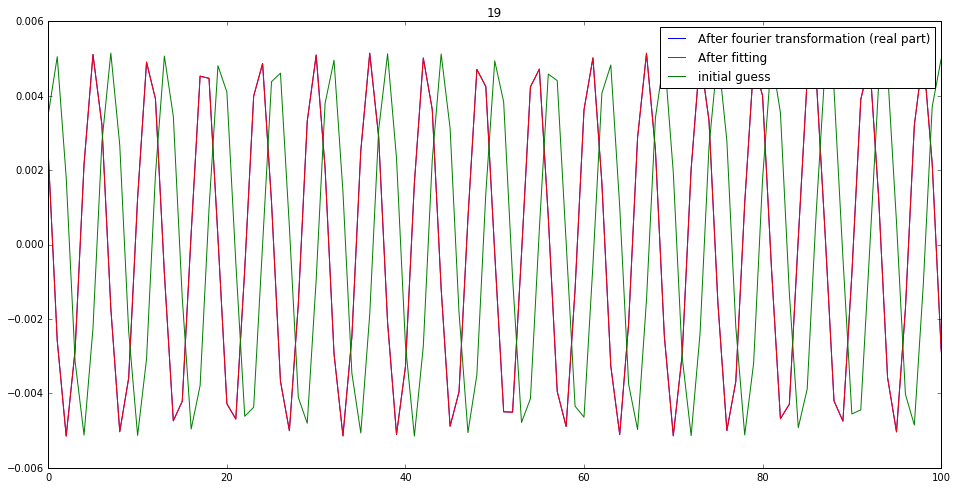

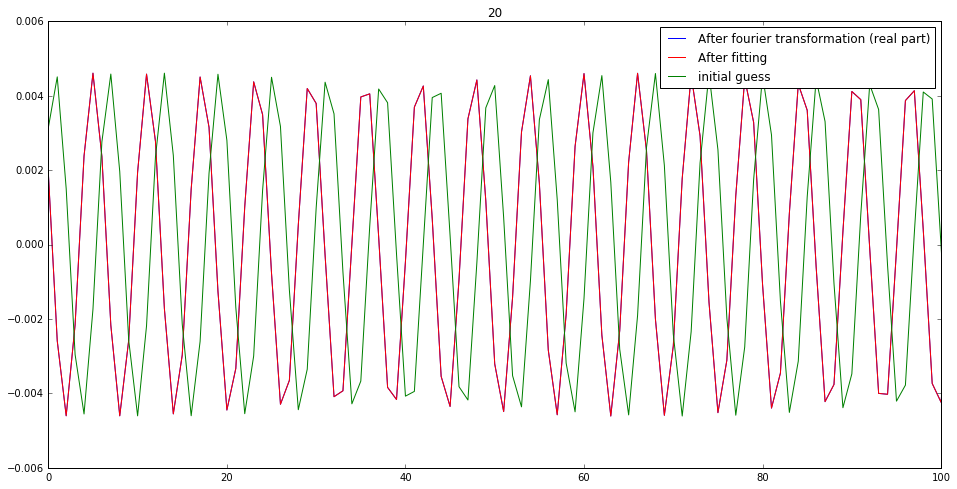

In [63]:
def my_sin(term2,amp,phase,n):
    return amp*np.sin(n*term2 + phase)

components_half=[3,4,5,6,7,8,13,14,20,99,138,139,140,146,147,148,149,150,151,152,154]
components_big=[3,99,138,139,140,146,147,148,149,150,151,152,154]

parameters = np.zeros(shape=(len(components_half),3))
for i in range(len(components_half)):
    fft_one_reflection = np.zeros(len(fft_component))
    fft_reflection = np.fft.ifft(gain_line_sub)#np.zeros(len(fft_component))#
    
    for kk in range(len(fft_reflection)):
        if kk != components_half[i]:
            fft_reflection[kk]=0
    
    fft_reflections_half = np.real(np.fft.fft(fft_reflection))
    N= len(freq_phase[50:990])
    term2 = np.arange(N) 
    
    guess_amplitude = np.max(fft_reflections_half)
    guess_phase = 0.75 #1.5 
    n=2*np.pi*components_half[i]/940
    if i==2:
        guess_phase = 1.5
    if i==9:
        guess_phase = np.pi


    guess_offset = np.mean(fft_reflections_half)
    
    p0=[ guess_amplitude, guess_phase, n]

    fit = curve_fit(my_sin, term2, fft_reflections_half, p0=p0)
    data_fit = my_sin(term2, *fit[0])
    
    fit_leastsq = leastsq(lambda p: my_sin(term2, *p) - fft_reflections_half, p0)
    parameters[i,:]= fit[0]
    
    if i in [0,1,2,3,4,5,6,7]:
        plt.figure(i+1)
        plt.plot(fft_reflections_half, label='After fourier transformation (real part)')
        plt.plot(data_fit ,'r' , label='After fitting')
        plt.plot(my_sin(term2,*p0), label='initial guess')
        #plt.plot(my_sin(term2, *fit_leastsq[0]),'.' , label='After fitting least square fitting')
        plt.title(i)
        plt.legend()
    else:    
        plt.figure(i+1)
        plt.plot(fft_reflections_half, label='After fourier transformation (real part)')
        plt.plot(data_fit ,'r' , label='After fitting')
        plt.plot(my_sin(term2,*p0), label='initial guess')
        #plt.plot(my_sin(term2, *fit_leastsq[0]),'.' , label='After fitting least square fitting')
        plt.title(i)
        plt.xlim(0,100)
        plt.legend()
    '''  
    plt.figure(i+1)
    plt.plot(fft_reflections_half,'.-', label='After fourier transformation (real part)')
    plt.plot(data_fit ,'r' , label='After fitting')
    plt.plot(my_sin(term2,*p0), label='initial guess')
    plt.plot(my_sin(term2, *fit_leastsq[0]),'.' , label='After fitting least square fitting')
    plt.title(i)
    plt.xlim(0,100)
    plt.legend()
    '''

# New model for gain

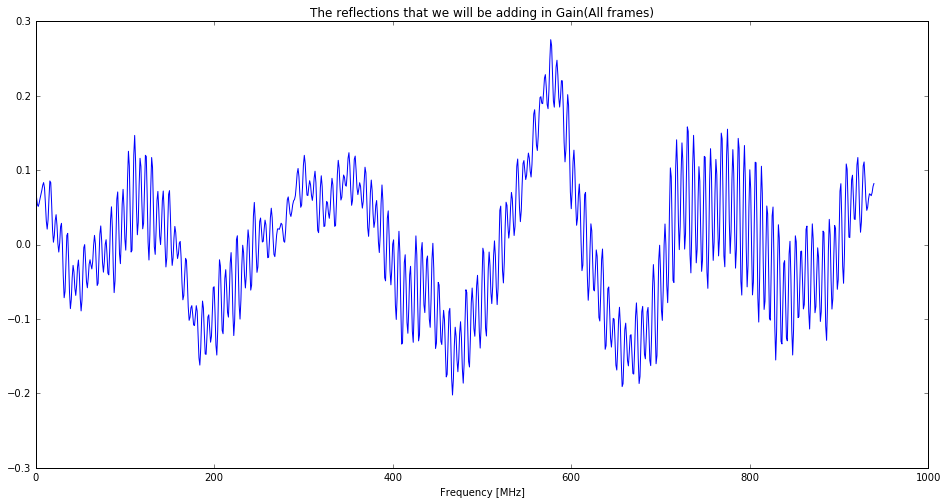

In [67]:

reflections_generate = np.zeros(len(gain_all[10,1,:]))
for k in range(21):
    reflections_generate = reflections_generate + my_sin(term2, *parameters[k,:])
plt.plot(reflections_generate)
plt.title('The reflections that we will be adding in Gain(All frames)')
plt.xlabel('Frequency [MHz]')

In [95]:
# I'm using reflections from cable 2 for a particulat time frame
kk=0
freq=462

#print(len(gain_all[:,1,freq]))
for k in range(len(corr_list)):
    m1=[]
    gain_total_std = np.std(gain_all[:,k,freq])
    m1 = (gain_all[:,k,freq]) > (np.mean(gain_all[:,k,freq])) - gain_total_std
    gain_per_frame = np.zeros(len(gain_all[m1,k,400]))
    gain_per_frame_600 = np.zeros(len(gain_all[m1,k,400]))
    
    '''
    for i in range(len(gain_all[m1,k,400])):
        masked_gain = []
        masked_gain = gain_all[]
        z=np.polyfit(term2, gain_all[i,k,:],1)
        p=np.poly1d(z)
        gain_per_frame = p(term2) + reflections_generate # we are multiplying by two to 
        #make sure that we are doubling the energy that we lost during fourier transformation
        gain_per_frame_600[i] = gain_per_frame[freq]
    
    frac_change_gain_new_model = (gain_per_frame_600 - np.mean(gain_per_frame_600))/np.mean(gain_per_frame_600)
    frac_change_gain_raw = (gain_all[m1,k,freq] - np.mean(gain_all[m1,k,freq]))/np.mean(gain_all[m1,k,freq])
    residual_new_model = frac_change_gain_raw - frac_change_gain_new_model
    
    plt.figure(1)
    plt.plot(residual_new_model, '.' , color = colors[kk])
    plt.title('Residual- New Reflection Model', size =20)
    plt.xlabel('Frame Bin or Frame Number', size =20)
    plt.ylim(-0.01,0.01)
    
    plt.figure(2)
    plt.subplot(4,2,k+1)
    plt.plot(frac_change_gain_new_model,'.', color=colors[kk])
    plt.plot(frac_change_gain_raw, 'k')
    '''
    
    print(len(gain_all[m1,k,400]))
    xx= gain_all[m1,k,400]
    print (len(xx))
    kk=kk+1
    

3378
2813
2813
2765
2765
3231
3231
3025
3025
2718
2718
2809
2809
2792
2792


# Creating reflection model for each cable seperately

In [ ]:
def my_sin(term2,amp,phase,n):
    return amp*np.sin(n*term2 + phase)

components_half=[3,4,5,6,7,8,13,14,20,99,138,139,140,146,147,148,149,150,151,152,154]
components_big=[3,99,138,139,140,146,147,148,149,150,151,152,154]

parameters = np.zeros(shape=(len(components_half),3))
for i in range(len(components_half)):
    fft_one_reflection = np.zeros(len(fft_component))
    fft_reflection = np.fft.ifft(gain_line_sub)#np.zeros(len(fft_component))#
    
    for kk in range(len(fft_reflection)):
        if kk != components_half[i]:
            fft_reflection[kk]=0
    
    fft_reflections_half = np.real(np.fft.fft(fft_reflection))
    N= len(freq_phase[50:990])
    term2 = np.arange(N) 
    
    guess_amplitude = np.max(fft_reflections_half)
    guess_phase = 0.75 #1.5 
    n=2*np.pi*components_half[i]/940
    if i==2:
        guess_phase = 1.5
    if i==9:
        guess_phase = np.pi


    guess_offset = np.mean(fft_reflections_half)
    
    p0=[ guess_amplitude, guess_phase, n]

    fit = curve_fit(my_sin, term2, fft_reflections_half, p0=p0)
    data_fit = my_sin(term2, *fit[0])
    
    fit_leastsq = leastsq(lambda p: my_sin(term2, *p) - fft_reflections_half, p0)
    parameters[i,:]= fit[0]
    
    if i in [0,1,2,3,4,5,6,7]:
        plt.figure(i+1)
        plt.plot(fft_reflections_half, label='After fourier transformation (real part)')
        plt.plot(data_fit ,'r' , label='After fitting')
        plt.plot(my_sin(term2,*p0), label='initial guess')
        #plt.plot(my_sin(term2, *fit_leastsq[0]),'.' , label='After fitting least square fitting')
        plt.title(i)
        plt.legend()
    else:    
        plt.figure(i+1)
        plt.plot(fft_reflections_half, label='After fourier transformation (real part)')
        plt.plot(data_fit ,'r' , label='After fitting')
        plt.plot(my_sin(term2,*p0), label='initial guess')
        #plt.plot(my_sin(term2, *fit_leastsq[0]),'.' , label='After fitting least square fitting')
        plt.title(i)
        plt.xlim(0,100)
        plt.legend()

 
-0.00349 x - 9.224


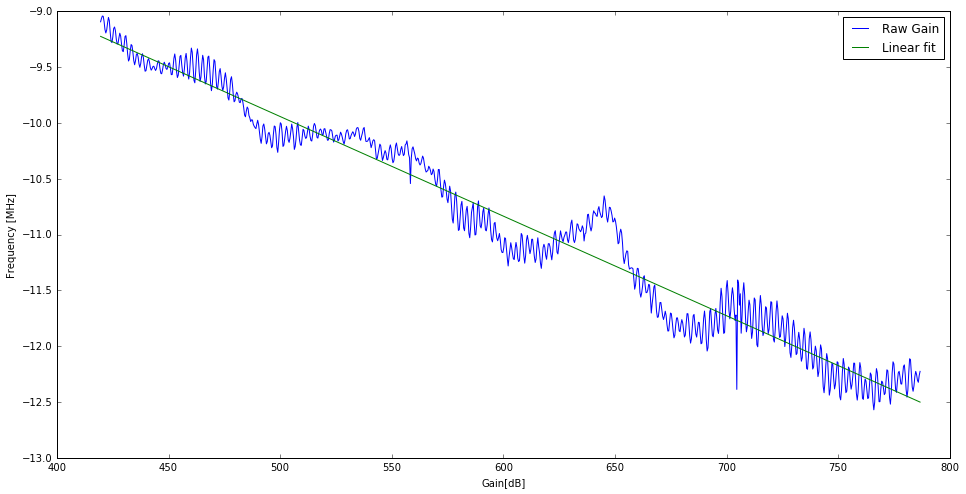

In [902]:
z=np.polyfit(term2, gain_all[10,1,:],1)
p=np.poly1d(z)
print(p)
plt.plot(freq_phase[50:990],gain_all[10,1,:], label='Raw Gain')
plt.plot(freq_phase[50:990],p(term2),label='Linear fit')

plt.legend()
plt.xlabel('Gain[dB]')
plt.ylabel('Frequency [MHz]')

#   different channels

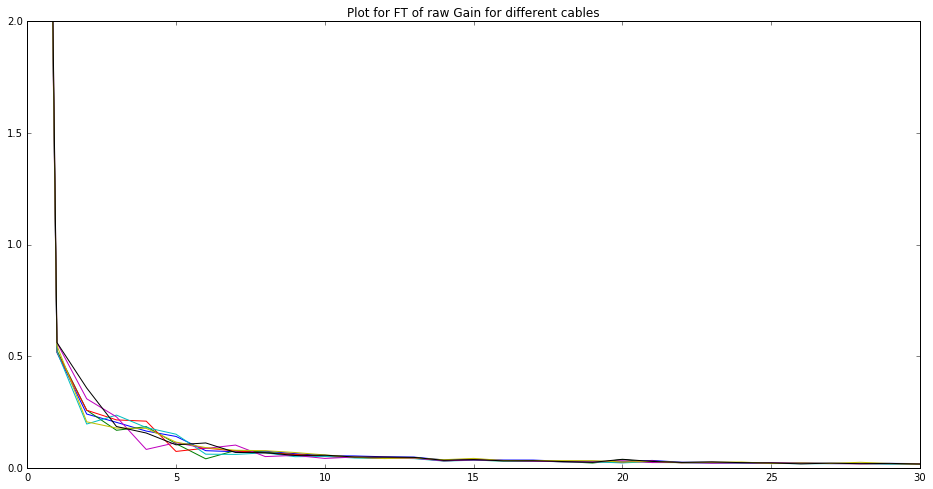

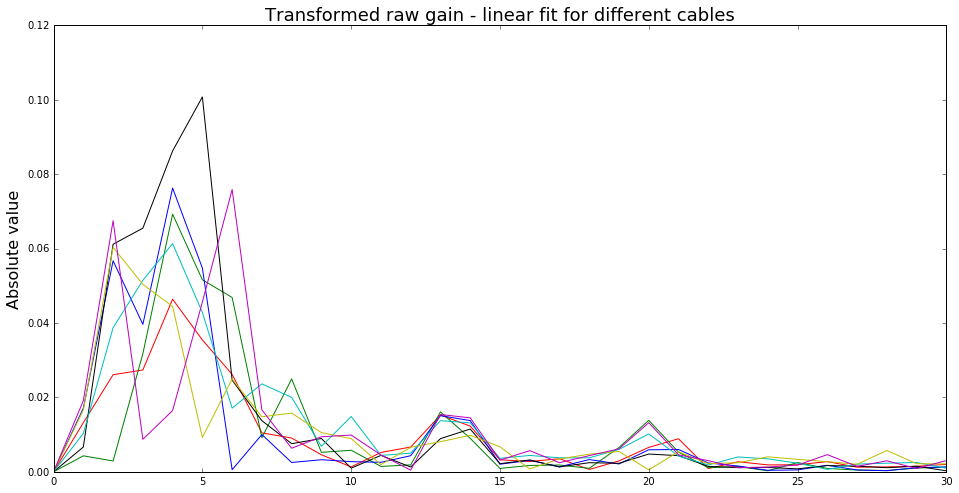

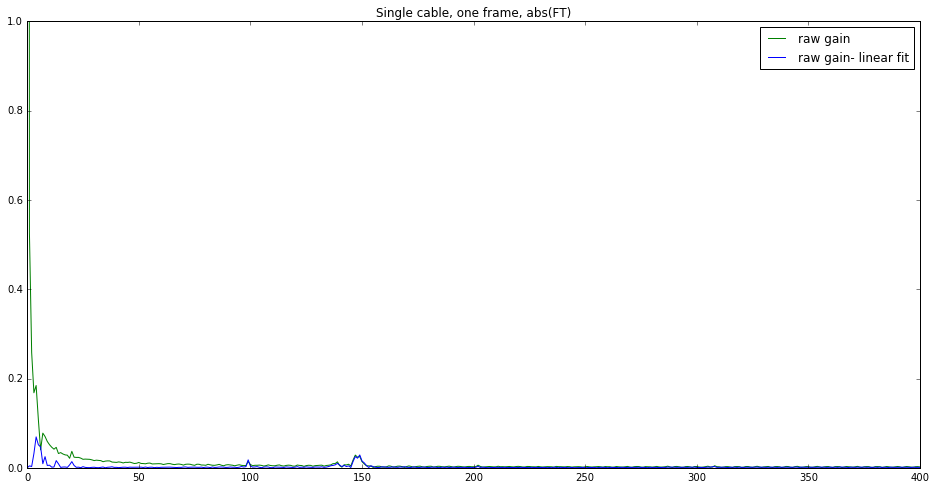

In [79]:
k=0
for i in range(7):
    gain_raw = gain_all[10,i,:]
    z=np.polyfit(freq_phase[50:990], gain_raw,2)
    p=np.poly1d(z)
    gain_line_sub = gain_raw - p(freq_phase[50:990])
    fft_component=np.fft.ifft(gain_line_sub) 
    
    plt.figure(1)
    plt.plot(abs(np.fft.ifft(gain_all[10,i,:])))
    plt.title('Plot for FT of raw Gain for different cables')
    plt.xlim(0,30)
    plt.ylim(0,2)
    
    plt.figure(2)
    plt.plot(abs(fft_component), color = colors[k])
    plt.xlim(0,30)
    plt.title('Transformed raw gain - linear fit for different cables', fontsize=18)
    plt.ylabel('Absolute value', fontsize=16)
    
   
    
    if i==1:
        plt.figure()
        plt.plot(abs(np.fft.ifft(gain_all[10,i,:])), color = colors[k], label='raw gain')
        plt.plot(abs(fft_component), color = colors[k+1], label='raw gain- linear fit')
        plt.title('Single cable, one frame, abs(FT)')
        plt.ylim(0,1)
        plt.xlim(0,400)
        plt.legend()
    k=k+1
    
# plot1: plot of FFT of raw gain 
# plot2: plot of FFT of raw fain - straight line 

# (NOT USING THIS ANY MORE )
# Here, I'm applying traditional way/usual way -> fft*filter and ifft on all cables one time frame 

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


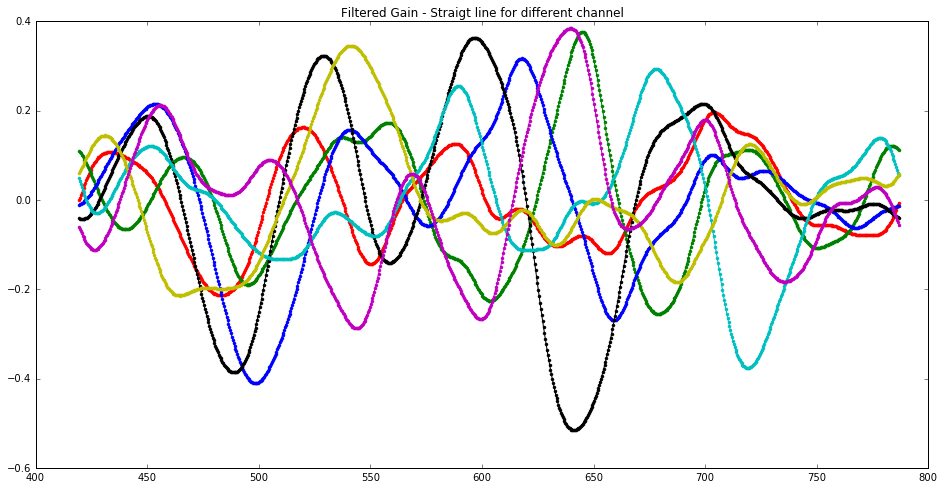

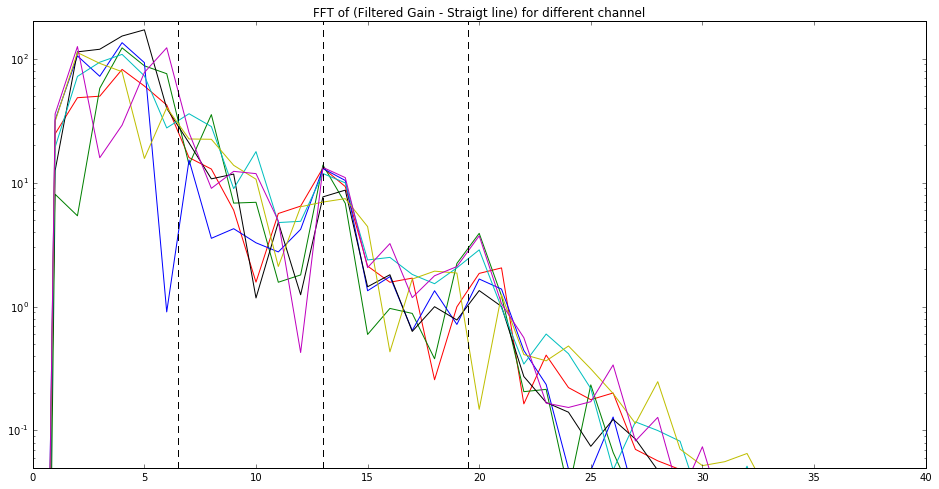

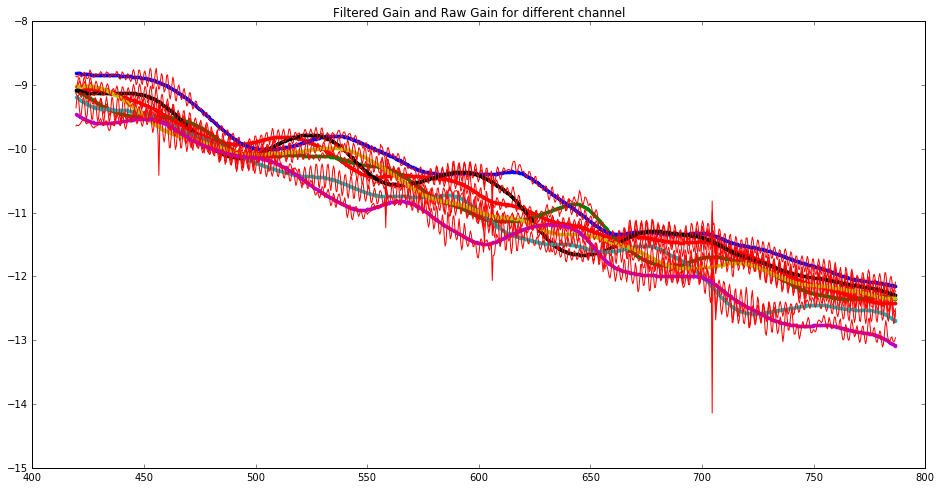

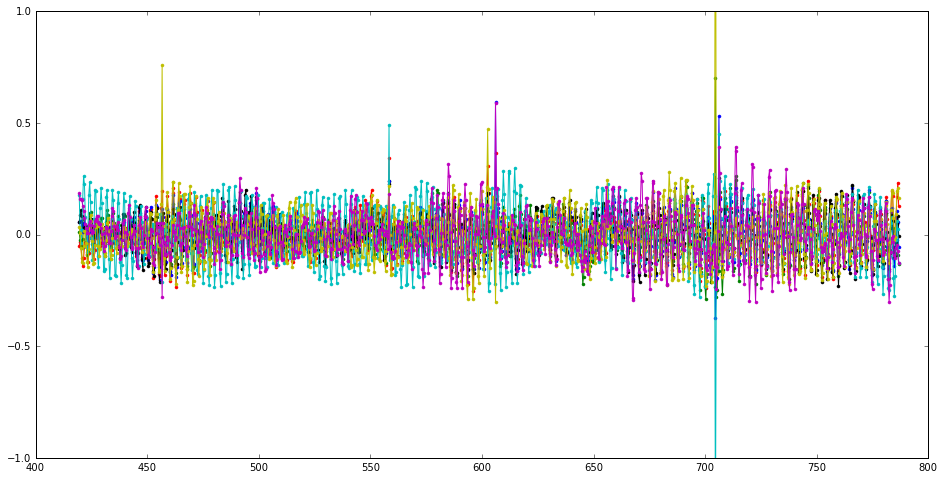

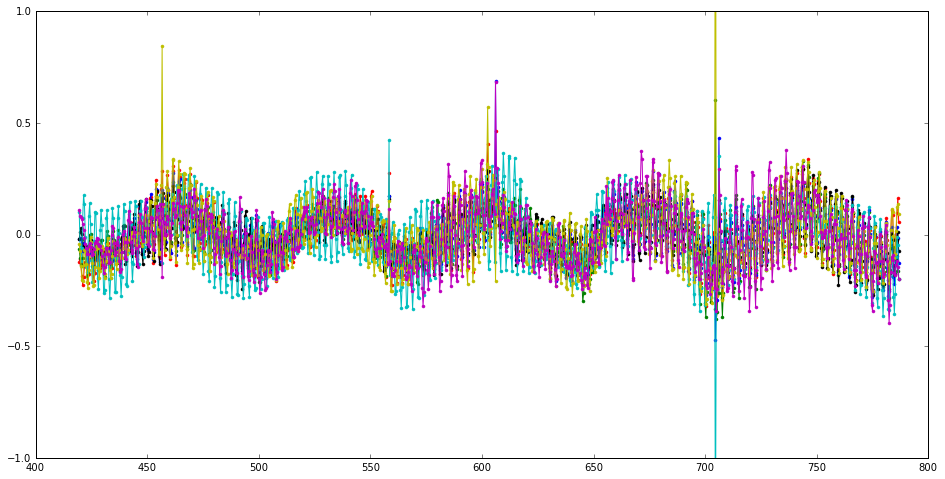

In [115]:
k=0
for i in range(7):
    gain_raw = gain_all[10,i,:]
    z=np.polyfit(freq_phase[50:990], gain_raw,2)
    p=np.poly1d(z)
    gain_line_sub = gain_raw - p(freq_phase[50:990])
    fft_component=np.fft.fft(gain_line_sub) 
    
    x_component = np.arange(len(freq_phase[50:990])) # setting the size
    filter_size =10 # Filter size
    #fft_component[filter_size:]=0
    z=np.arange(len(fft_component))
    

    #df=0.03
    f1=np.exp(-z**2/(2.*filter_size**2))
    f2=np.exp(-(1.-z)**2/(2.*filter_size**2))
    fil=f1+f2

    fft_component_filter = (fft_component)*fil#np.exp(-z**2/(2.*filter_size**2))
    filtered_gain = np.fft.ifft(fft_component_filter) + p(freq_phase[50:990])
    plt.figure(3)
    #plt.title('filtered IFFT filter_size %i' %(filter_size), size =20)
    plt.plot(freq_phase[50:990],filtered_gain- p(freq_phase[50:990]),'.-',color = colors[k])
    plt.title('Filtered Gain - Straigt line for different channel')

    plt.figure(4)
    coarse_spect=np.fft.fft(filtered_gain- p(freq_phase[50:990]))
    plt.plot(np.abs(coarse_spect[0:40]),color = colors[k])
    plt.title('FFT of (Filtered Gain - Straigt line) for different channel')
    plt.axvline(6.5, color='k', linestyle='--')
    plt.axvline(6.5*2, color='k', linestyle='--')
    plt.axvline(6.5*3, color='k', linestyle='--')
    plt.yscale('log')
    plt.ylim(.05,200.)

    plt.figure(5)
    plt.plot(freq_phase[50:990],filtered_gain,'.-',color = colors[k])
    plt.plot(freq_phase[50:990],gain_raw,'r')
    plt.title('Filtered Gain and Raw Gain for different channel' )

    plt.figure(6)
    plt.plot(freq_phase[50:990],filtered_gain-gain_raw,'.-',color = colors[k])
    #plt.plot(freq_phase[50:990],.1*np.sin(2.*3.14*(freq_phase[50:990]-410.)/70.),'r')
    #plt.plot(freq_phase[50:990],.1*np.sin(2.*3.14*(freq_phase[50:990]-410)/63.),'c')
    plt.title('')
    #plt.legend('difference','marks plot','my trial')
    plt.ylim([-1,1])
    
    plt.figure(7)
    plt.plot(freq_phase[50:990],filtered_gain-gain_raw-.1*np.sin(2.*3.14*(freq_phase[50:990]-410.)/70.),'.-',color = colors[k])
    plt.ylim([-1,1])
    k=k+1

# USING FIRST TWO PLOTS ONLY
# Doing same as above for one channel but different frames

500


C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


499
500


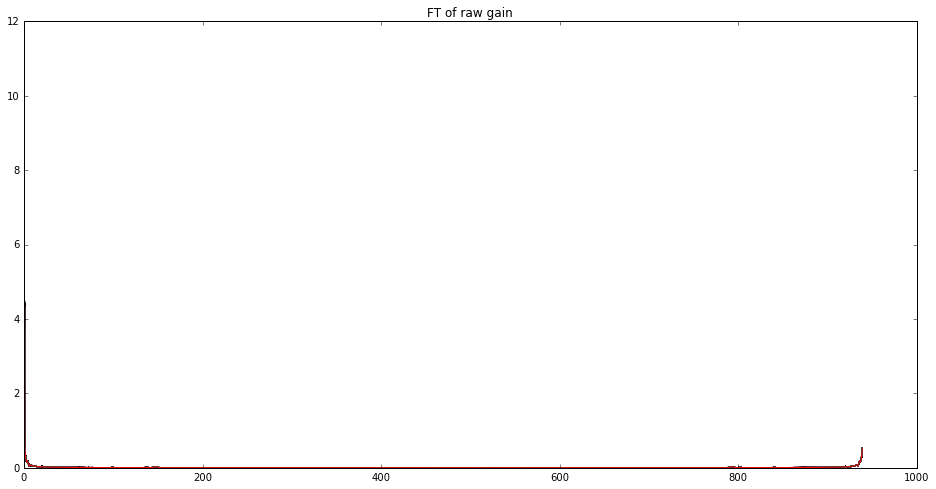

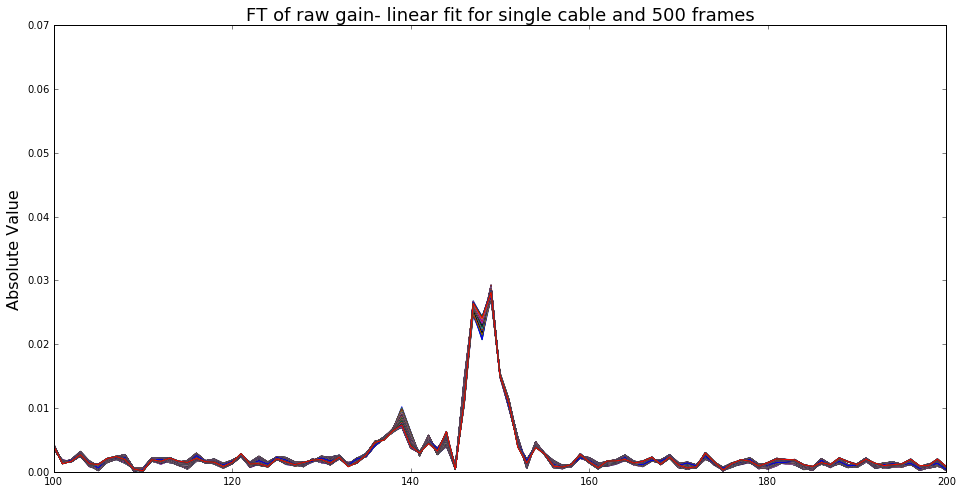

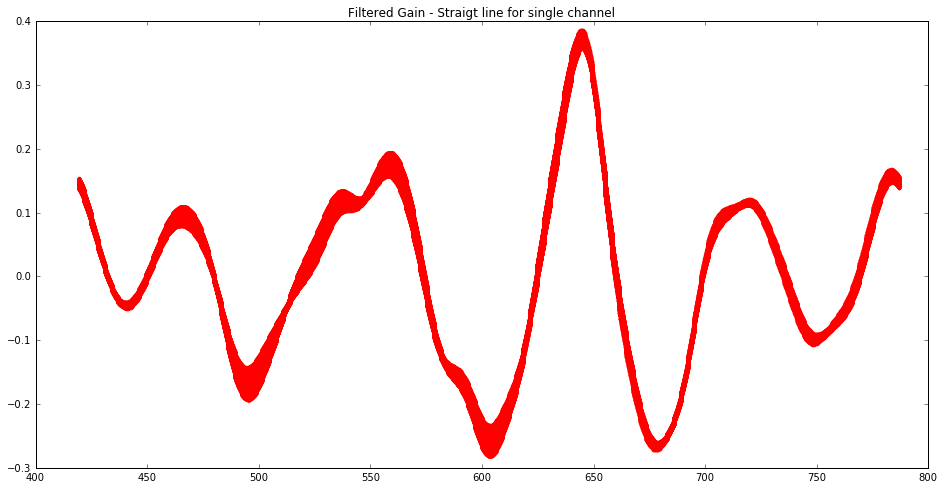

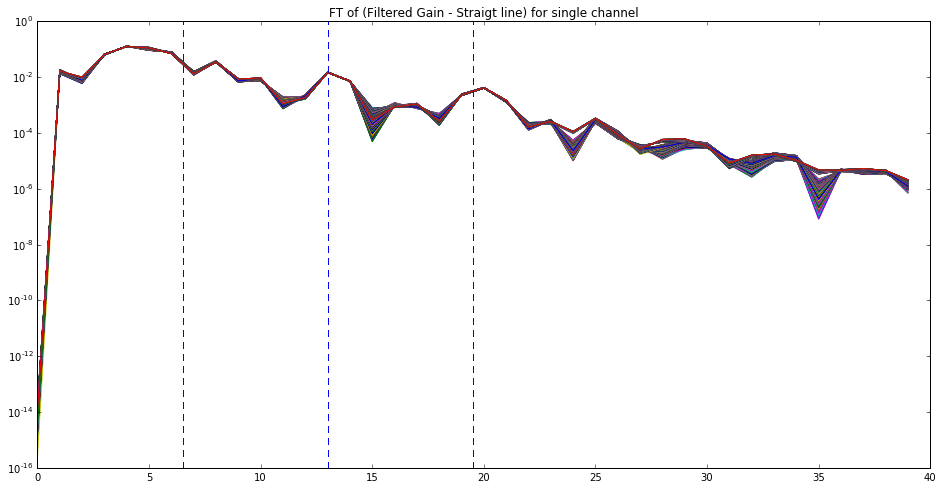

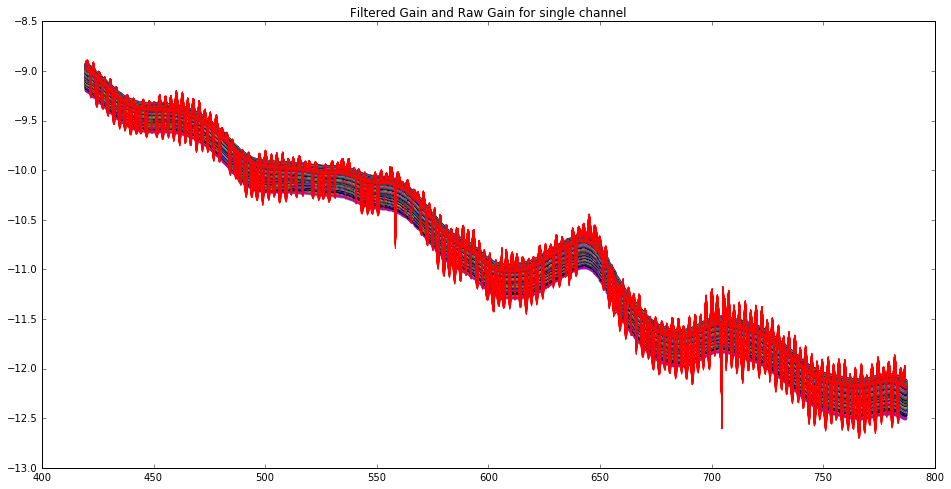

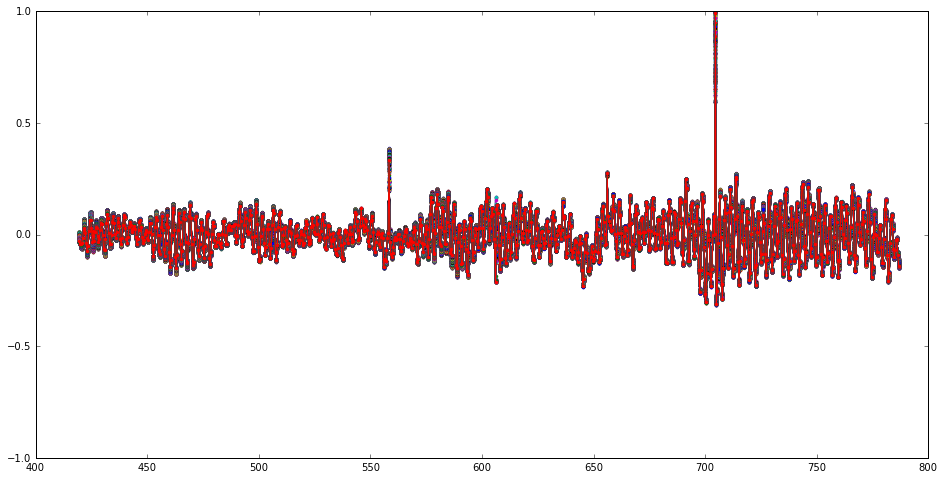

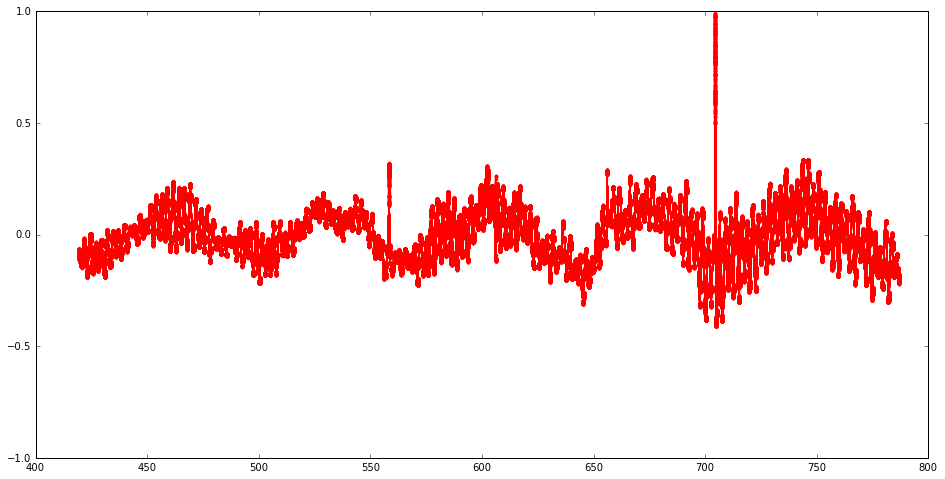

In [78]:
k=0
frame_numbers = np.linspace(0, 3000, num=500)
print(len(frame_numbers))
count=0
#print(len(gain_all[:,1,1]))

for i in range(len(frame_numbers)):
    count=count+1
    gain_raw = gain_all[i,1,:]
    z=np.polyfit(freq_phase[50:990], gain_raw,1)
    p=np.poly1d(z)
    gain_line_sub = gain_raw - p(freq_phase[50:990])
    fft_component=np.fft.ifft(gain_line_sub) 

    plt.figure(1)
    plt.plot(np.abs(np.fft.ifft(gain_all[i,1,:])))
    plt.title('FT of raw gain')
    #plt.xlim(0,50)
    
    plt.figure(2)
    plt.plot(np.abs(fft_component))
    plt.title('FT of raw gain- linear fit for single cable and 500 frames', fontsize=18)
    plt.xlim(100,200)
    plt.ylabel('Absolute Value', fontsize=16)
    #plt.ylim(0,0.05)
    
    x_component = np.arange(len(freq_phase[50:990])) # setting the size
    filter_size =10 # Filter size
    #fft_component[filter_size:]=0
    z=np.arange(len(fft_component))

    #df=0.03
    f1=np.exp(-z**2/(2.*filter_size**2))
    f2=np.exp(-(1.-z)**2/(2.*filter_size**2))
    fil=f1+f2

    fft_component_filter = (fft_component)*fil#np.exp(-z**2/(2.*filter_size**2))
    filtered_gain = np.fft.fft(fft_component_filter) + p(freq_phase[50:990])
    
    
    plt.figure(3)
    #plt.title('filtered IFFT filter_size %i' %(filter_size), size =20)
    plt.plot(freq_phase[50:990],filtered_gain- p(freq_phase[50:990]),'.-',color = colors[k])
    plt.title('Filtered Gain - Straigt line for single channel')

    plt.figure(4)
    coarse_spect=np.fft.ifft(filtered_gain- p(freq_phase[50:990]))
    plt.plot(np.abs(coarse_spect[0:40]))
    plt.title('FT of (Filtered Gain - Straigt line) for single channel')
    plt.axvline(6.5,  linestyle='--')
    plt.axvline(6.5*2,  linestyle='--')
    plt.axvline(6.5*3,  linestyle='--')
    plt.yscale('log')
    #plt.ylim(.05,200.)

    plt.figure(5)
    plt.plot(freq_phase[50:990],filtered_gain,'.-')
    plt.plot(freq_phase[50:990],gain_raw,'r')
    plt.title('Filtered Gain and Raw Gain for single channel' )

    plt.figure(6)
    plt.plot(freq_phase[50:990],filtered_gain-gain_raw,'.-')
    #plt.plot(freq_phase[50:990],.1*np.sin(2.*3.14*(freq_phase[50:990]-410.)/70.),'r')
    #plt.plot(freq_phase[50:990],.1*np.sin(2.*3.14*(freq_phase[50:990]-410)/63.),'c')
    plt.title('')
    #plt.legend('difference','marks plot','my trial')
    plt.ylim([-1,1])
    
    plt.figure(7)
    plt.plot(freq_phase[50:990],filtered_gain-gain_raw-.1*np.sin(2.*3.14*(freq_phase[50:990]-410.)/70.),'.-',color = colors[k])
    plt.ylim([-1,1])
    
print(i)
print (count)

[  1.33786799e-02   6.96475634e+01   5.63581604e+00   5.32989085e-01
   9.54282234e+01   6.09748306e-06]


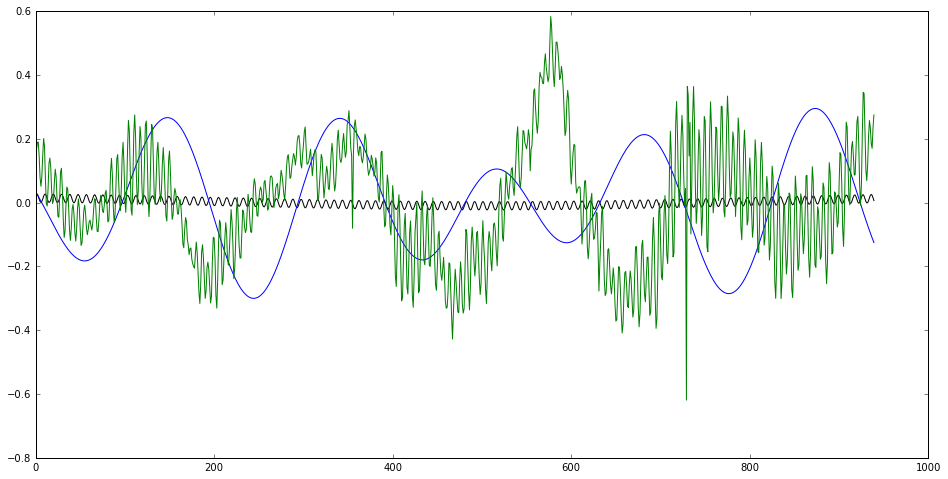

In [422]:
# Working on reflection model
gain_line_sub = gain_all[10,1,:] - p(freq_phase[50:990])
def gain_fit_ref1(x,*p):
    #return p[0]*np.sin(2*np.pi*(x-410)/p[1]) + p[2]*np.sin(2*np.pi*(x-410)/p[3]) #+p[4]*x 
    return p[0]*(np.cos(2*np.pi*p[1]*x/(0.84*300)+p[2]) + np.cos(2*np.pi*p[3]*x/(0.84*300)+p[4])) + p[5]*x
para_ref1,conv = curve_fit(gain_fit_ref1, freq_phase[50:990], gain_line_sub, p0=(3*np.std(gain_line_sub)/(2**0.5),70,1,0.1,100,np.mean(gain_line_sub)))
plt.figure(1)
plt.plot(gain_fit_ref1(freq_phase[50:990],*para_ref1), 'k')
print(para_ref1)

z=np.polyfit(freq_phase[50:990], gain_all[10,1,:],1)
p=np.poly1d(z)
N = 1000 # number of data points
reflection1 = 0.2*np.cos(2*np.pi*(freq_phase[50:990]-410)/70)
reflection2 = 0.1*np.cos((2*np.pi*freq_phase[50:990]-410)/100)
data = reflection1 + reflection2 + reflection3
plt.plot(data)
plt.plot(gain_line_sub)

plt.figure(2)
fitfunc = lambda p, x:  p[0]*np.cos(2*np.pi*p[1]*x/(0.84*300)+p[2]) + p[3]*np.cos(2*np.pi*p[4]*x/(0.84*300)+p[5]) + p[6]*x# Target function
errfunc = lambda p, x, gain_line_sub: fitfunc(p, x) - gain_line_sub
p0 = [-15., 0.8, 0., -1.] # Initial guess for the parameters
#p1, success = optimize.leastsq(errfunc, p0[:], args=(Tx, tX))



-4.98523493416 -0.0106156246797 1.40115210151e-06
0 0


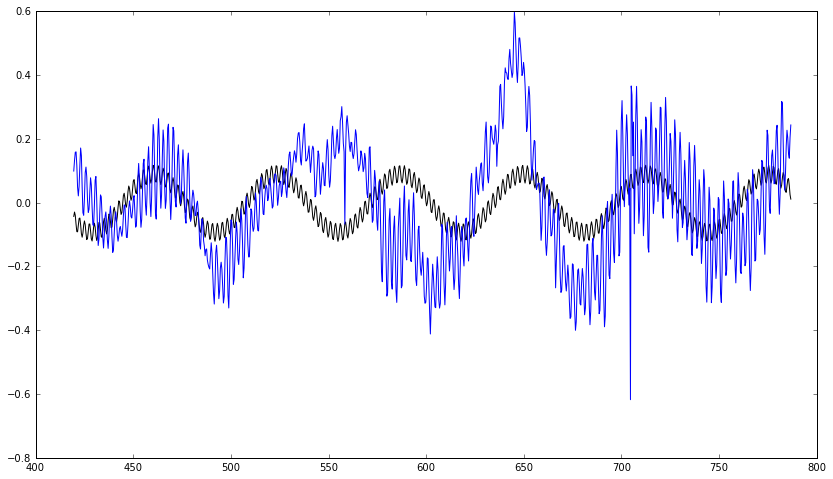

In [64]:
def gain_fit_3(x,*p):
    return p[0]*(np.cos(2*np.pi*100*x/(0.84*300)+p[2])) + p[3]*(np.cos(2*np.pi*4*x/(0.84*300)+p[1])) +p[4]*x 

para_3,conv = curve_fit(gain_fit_3, freq_phase[50:990], gain_all[10,1,:]-p(freq_phase[50:990]), p0=(1,1,1,1,1))

plt.plot(freq_phase[50:990],gain_fit_3(freq_phase[50:990],*para_3), 'k')
plt.plot(freq_phase[50:990], gain_all[10,1,:]-p(freq_phase[50:990]))

# not using this anymore
# here I'm trying to resolve the components from FFT, set filter based on first and second and more reflections
In this we are just wondring about first reflection

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.05, 200.0)

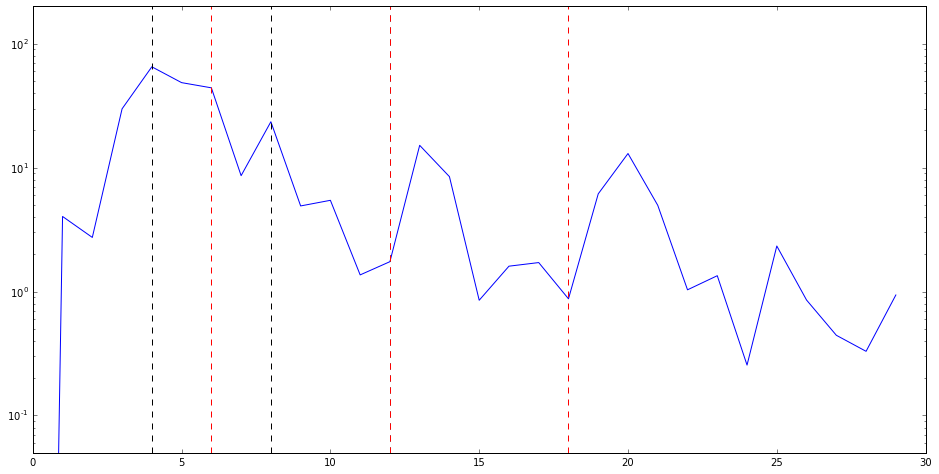

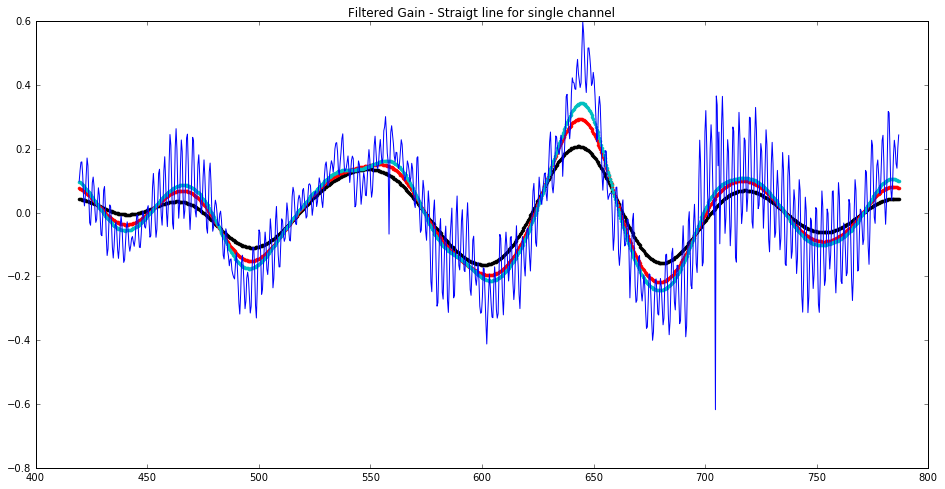

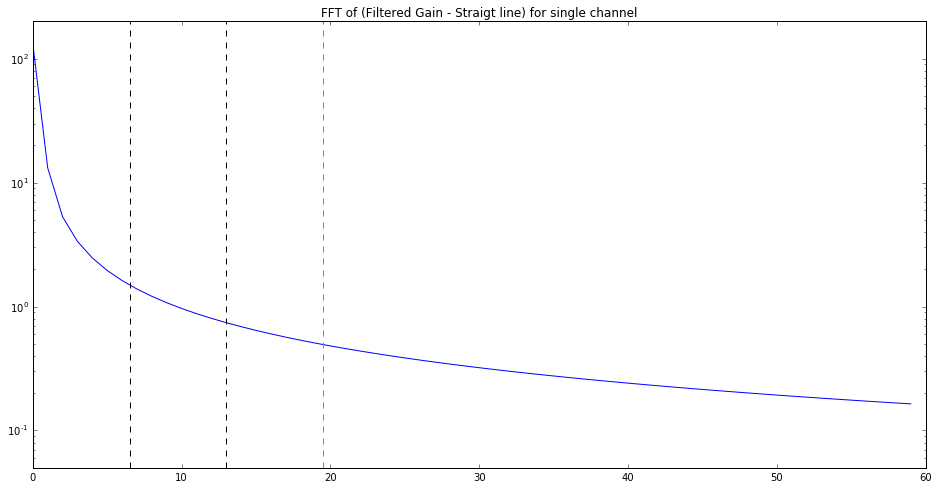

In [905]:
z=np.polyfit(freq_phase[50:990], gain_all[10,1,:],2)
p=np.poly1d(z)
gain_line_sub = gain_all[10,1,:] - p(freq_phase[50:990])
fft_component=np.fft.fft(gain_line_sub) 

############### This section will decide the filter size for getting first reflection coefficient
plt.figure()
course_spect1 = fft_component
plt.plot(np.abs(course_spect1[0:30]))
plt.yscale('log')
plt.ylim(.05,200.)
plt.axvline(4, color='k', linestyle='--')
plt.axvline(4*2, color='k', linestyle='--')
plt.axvline(4*3, color='k', linestyle='--')

plt.axvline(6, color='r', linestyle='--')
plt.axvline(6*2, color='r', linestyle='--')
plt.axvline(6*3, color='r', linestyle='--')
################# i decidede to set filter size =4

x_component = np.arange(len(freq_phase[50:990])) # setting the size
#fft_component[filter_size:]=0
z=np.arange(len(fft_component))

filter_size =4 # Filter size
f1=np.exp(-z**2/(2.*filter_size**2))
f2=np.exp(-(1.-z)**2/(2.*filter_size**2))
fil_4=f1+f2
fft_component_filter_4 = (fft_component)*fil_4#np.exp(-z**2/(2.*filter_size**2))
filtered_gain_4 = np.fft.ifft(fft_component_filter_4) + p(freq_phase[50:990])

filter_size =6 # Filter size
f1=np.exp(-z**2/(2.*filter_size**2))
f2=np.exp(-(1.-z)**2/(2.*filter_size**2))
fil_6=f1+f2
fft_component_filter_6 = (fft_component)*fil_6#np.exp(-z**2/(2.*filter_size**2))
filtered_gain_6 = np.fft.ifft(fft_component_filter_6) + p(freq_phase[50:990])

filter_size =8 # Filter size
f1=np.exp(-z**2/(2.*filter_size**2))
f2=np.exp(-(1.-z)**2/(2.*filter_size**2))
fil_8=f1+f2
fft_component_filter_8 = (fft_component)*fil_8#np.exp(-z**2/(2.*filter_size**2))
filtered_gain_8 = np.fft.ifft(fft_component_filter_8) + p(freq_phase[50:990])

filter_size =10 # Filter size
f1=np.exp(-z**2/(2.*filter_size**2))
f2=np.exp(-(1.-z)**2/(2.*filter_size**2))
fil_10=f1+f2
fft_component_filter_10= (fft_component)*fil_10#p.exp(-z**2/(2.*filter_size**2))
filtered_gain_10= np.fft.ifft(fft_component_filter_10 + p(freq_phase[50:990]))

plt.figure()
#plt.title('filtered IFFT filter_size %i' %(filter_size), size =20)
plt.plot(freq_phase[50:990],filtered_gain_4- p(freq_phase[50:990]),'.-k', label = 'filter size=4')
plt.plot(freq_phase[50:990],filtered_gain_6- p(freq_phase[50:990]),'.-r', label = 'filter size=6')
plt.plot(freq_phase[50:990],filtered_gain_8- p(freq_phase[50:990]),'.-c', label = 'filter size=8')
#plt.plot(freq_phase[50:990],filtered_gain_10- p(freq_phase[50:990]),'.-g', label = 'filter size=10')                             
plt.plot(freq_phase[50:990], gain_all[10,1,:]-p(freq_phase[50:990]), label='Measured gain')
plt.title('Filtered Gain - Straigt line for single channel')
#lt.legend('filter size=4','filter size=6','filter size=8','filter size=10')


plt.figure()
coarse_spect=np.fft.fft(filtered_gain- p(freq_phase[50:990]))
plt.plot(np.abs(coarse_spect[0:60]))
plt.title('FFT of (Filtered Gain - Straigt line) for single channel')
plt.axvline(6.5, color='k', linestyle='--')
plt.axvline(6.5*2, color='k', linestyle='--')
plt.axvline(6.5*3, color='c', linestyle='--')
plt.yscale('log')
plt.ylim(.05,200.)